# **Identify a deafault client (CREDIT SCORING)**

This work has made in cooperation with Vetak8
#### [GitHub](https://github.com/vetak8)
#### [Kaggle](https://www.kaggle.com/vitaliyburlakov)

<img src = 'https://www.nationalvanguard.org/wp-content/uploads/2016/03/debt-slave.jpg' width='400px' >

<a id="sec1"></a>
# [Description](#sec1)

The Main target of the project is to classify default clients (who tend to overdue payment). The model shall return probability of classified client.

<a id="sec1.1"></a>
## [Features Defination](sec1.1)

client_id -  client ID

education - the level of education

sex - borrowe's gender

age - borrowers age

car - has(has no) car

car_type - flag of car type

decline_app_cnt - number of rejected past applications

good_work - good job flag

bki_request_cnt - number of requests to Credit bureau

home_address - home address categorizer 

work_address - work address categorizer 

income - borrower's income

foreign_passport - has (has no) traveling passport

sna - Relationships of borrower with the bank's clients

first_time - how old the information about the borrower was

score_bki - score based on data from Credit bureau

region_rating - region rating

app_date - application date

default - has (has no) default

<a id="sec2"></a>
# [INDEX](#sec2)

<a id="sec1"></a>
1. [Description](#sec1)
   * [1.1 Features Defination](#sec1.1)
2. [INDEX](#sec2)
3. [IMPORT LIBRARRIES](#sec3)
4. [Functions and Classes](#sec4)
5. [Load and Chek the Dataset](#sec5)
    * [Data Types](#sec5.1)
    * [Pandas Profiling](#sec5.2)
6. [ANALYZE DATA](#sec6)
    * [Bolean Feature analysis](#sec6.1)
    * [Categorical Feature analysis](#sec6.2)
    * [Numerical Feature analysis](#sec6.3)
    * [Date_Time analysis](#sec6.4)
    * [Draw a conclusion](#sec6.5)
7. [Naive Model](#sec7)
8. [Feature Engineering](#sec8)
    * [Create New features](#sec8.1)
    * [ENCODING](#sec8.2)
    * [LOGARITHM](#sec8.3)
    * [Feature Scaling](#sec8.3)
9. [Models](#sec9)
    * [9.1 LOG REGRESSION (naive)](#sec9.1)
    * [9.2 LOG REGRESSION (CrosValid & GridSearch)](#sec9.2)
    * [9.3 LOG REGRESSION Oversampling](#sec9.3)
    * [9.4 LOG REGRESSION Undersampling](#sec9.4)
    * [9.5 Random Forest_Naive](#sec9.5)
    * [9.6 Random Forest_GridSearch](#sec9.6)
    * [9.7 Random Forest_OverSampling](#sec9.7)
    * [9.8 Random Forest_UnderSampling](#sec9.8)
    * [9.9 Gradient BOOSTERS](#sec9.9)
        * [9.9.1 Prepare Data](#sec9.9.1)
        * [9.9.2 LightGBM](#sec9.9.2)
        * [9.9.3 LightGBM_Gridsearch](#sec9.9.3)
        * [9.9.4 CATBOOST & OPTUNA parameters Search](#sec9.9.4)
    * [9.10 Stacking_OverSample](#sec9.10)
10. [Conclusions](#sec10)
11. [SUBMISSION](#sec11)



<a id="sec3"></a>
# [IMPORT LIBRARRIES](sec3)
[(INDEX)](#sec2)

In [1]:
import os
import sklearn
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as cb
import optuna
from datetime import datetime
import warnings

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import f_classif, mutual_info_classif

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score,plot_roc_curve
from sklearn.metrics import classification_report, precision_score, recall_score, plot_precision_recall_curve
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm



from sklearn.model_selection import cross_val_score
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance

warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
#fix the version of the packages so that the experiments are reproducible:
!pip freeze > requirements.txt

In [3]:
# Lock a RANDOM SEED to keep experiments reproducible.
RANDOM_SEED = 42

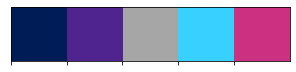

In [4]:
# Set project colors
colors = ['#001c57', '#50248f', '#a6a6a6', '#38d1ff','#cc3181']
sns.palplot(sns.color_palette(colors))

In [5]:
# INPUT_PATH = ''

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
#         INPUT_PATH = dirname

# if INPUT_PATH == '':
#     raise Exception('The input path is empty!')
# else:
#     print('\nWorking dir:', INPUT_PATH)

<a id="sec4"></a>
# [Functions and Classes](#sec4)
[(INDEX)](#sec2)

In [6]:
def pandas_report(data):
    ''' Function is called for generating of dataset profile-report'''

    profile = data.profile_report(
        title='Credit Scoring',
        progress_bar=False,
        correlations={
            'pearson': {'calculate': True},
            'spearman': {'calculate': True},
            'kendall': {'calculate': False},
            'phi_k': {'calculate': False},
            'cramers': {'calculate': False}        
        },
        
        interactions={
            'continuous': True,
            'targets': []
        },
        missing_diagrams={
            'heatmap': True,
            'dendrogram': True,
            'matrix': True
        },
        vars={
            'cat' : {'n_obs':10}
        }
    )
    
    return profile

In [7]:
def get_boxplot(data, col1, col2, hue=None):
    '''Function is called to plot boxplots'''
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.boxplot(x=col1, y=col2, hue=hue, data=data, palette=colors)
    plt.xticks(rotation=45)
    ax.set_title(f'Boxplot for {col1} and {col2}', fontsize=14)
    plt.show()

In [8]:
class Preprocessing:
    def __init__(self, data):
        self.data = data

    def label_encoder(self, column):
        le = LabelEncoder()
        self.data[column] = le.fit_transform(self.data[column])

    def hot_enc(self, column):
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        aux_df = pd.DataFrame(ohe.fit_transform(self.data[[column]]))
        aux_df.columns = ohe.get_feature_names([f'hot_{column}'])
        self.data = self.data.drop(col, axis=1)
        self.data = pd.concat([self.data, aux_df], axis=1)
        return self.data     

In [9]:
def missing_vars(data, col='education', random_proba=True):
    '''Function is called for filling of missing data'''
    # With using probability and random choise

    if random_proba:
        col_name = data[col].value_counts().index.to_list(
        )  # get list of values
        col_distr = data[col].value_counts(
            normalize=True).values  # get l;ist of probs
        missing = data[col].isnull()  # flag of missing val
        # substitute values from the list of names in accordance with the probability of meeting the name
        data.loc[missing, [col]] = np.random.choice(col_name,
                                                    size=len(data[missing]),
                                                    p=col_distr)

    # Using  most common in  column
    data[col] = data[col].fillna(data[col].value_counts().index[0])

In [10]:
def corr_matrix(data, det=True, pltx=10, plty=10):
    '''Funcion is called for making correlation matrix'''
    
    X = data.corr()
    if det:
        
        evals,evec = np.linalg.eig(X)
        ev_product = np.prod(evals)
    
        print(f'Rank of Matrix: {np.linalg.matrix_rank(X)}')
        print(f'Determinant of matrix: {np.round(ev_product,4)}')
        print(f'Shape of matrix: {np.shape(X)}')
    
    plt.figure(figsize=(pltx,plty))
    sns.heatmap(X,vmin=0,vmax=.9,annot=True,square=True)
    plt.show()

In [11]:
def get_num_info(col, title=None):
    '''Function is called to plot feture distribution'''

    title = title if title is not None else f"Distribution for '{col}"
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5),)
    fig = sm.qqplot(col, fit=True, line='45', ax=ax1)
    fig.suptitle(title, fontsize=20)

    sns.distplot(col.values, bins=20, color=colors[1], ax=ax2)
    sns.violinplot(col.values, color=colors[3], bw=.3, cut=1, linewidth=4)

    ax1.set_title('QQ-plot')
    ax2.set_title('Distribution')
    ax3.set_title('Violinplot')

    plt.show()

In [12]:
def detect_outliers(data):
    '''Function is called to detect outliers'''
    q1, q3 = np.percentile(sorted(data), [25, 75])

    IQR = q3 - q1

    l_b = q1 - (1.5 * IQR) # lower bound
    u_b = q3 + (1.5 * IQR) # upper bound
    outl_count = len(data[data < l_b]) + len(data[data > u_b])

    print(
        f'Lower Bound: {round(l_b,3)}, Upper Bound {round(u_b,3)}, Outliers Count: {outl_count}')

In [13]:
'''Function that returns the ordinal day of the year'''
def get_days_count(x):  
    day = ((x.month-1) * 30)+x.day
    return day
'''A function that returns the number of days between the order date and today's date'''
def get_days_beetwen(x):
    curr_date = datetime.today()
    count = (curr_date-x).days
    return count
    
'''Function that returns the flag of filing an application on a weekend'''
def if_weekend(x):
    if x.weekday() in [5,6]:
        return 1
    else:
        return 0
    
'''Function that returns month'''
def month(x):
    month = x.month
    return month

In [14]:
def make_confusion_matrix(cf,
                          group_names=['TN', 'FP', 'FN', 'TP'],
                          categories='auto',
                          sum_stats=True,
                          count=True,
                          cbar=True,
                          percent=True,
                          cmap='BuPu'):
    '''Function is called for making a confusion matrix
    args
    ------
    cf - confusion matrix
    group_names - Names for each group
    categories -  categories to be displayed on the x,y axis. Default is 'auto'
    sum_stats -   shows Accuracies. Deafult is TRUE
    c_bar -       If True, show the color bar. The cbar values are based off the values in the confusion matrix. 
                  Default is True
    percent -     to be displayed on the x,y axis. Default is True
    '''
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    group_labels = ["{}\n".format(value) for value in group_names]

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = [
            "{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)
        ]
    else:
        group_percentages = blanks

    box_labels = [
        f"{v1}{v2}{v3}".strip()
        for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)
    ]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # Metrics
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy = np.trace(cf) / float(np.sum(cf))
        ball_accuracy = .5 * (cf[1, 1] / sum(cf[1, :]) +
                              cf[0, 0] / sum(cf[0, :]))

        # if it is a binary confusion matrix, show some more stats
        if len(cf) == 2:
            # pr = how many real true
            precision = cf[1, 1] / sum(cf[:, 1])
            # How many positives from all positives
            recall = cf[1, 1] / sum(cf[1, :])
            # F1 score
            f1_score = 2 * precision * recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nBallancedAcc={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy, ball_accuracy, precision, recall, f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    plt.rcParams.get('figure.figsize')
    plt.figure(figsize=(5, 5))
    sns.heatmap(cf,
                annot=box_labels,
                fmt="",
                cmap=cmap,
                cbar=cbar,
                xticklabels=categories,
                yticklabels=categories)
    plt.ylabel('True label')
    plt.xlabel('Predicted label' + stats_text)

In [15]:
def make_roc_auc(model, X, y):
    '''Plot ROC-AUC and PR curves'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    plot_precision_recall_curve(model, X, y, ax=ax1)
    plot_roc_curve(model, X, y, ax=ax2)
    plt.show()

In [16]:
def get_scores(report_df, model, X_test, y_test, name):
    '''Create and add metrics into a pandas DF after experiment'''

    report = pd.DataFrame(columns={'ROC-AUC'}, data=[0])
    report['ROC-AUC'] = roc_auc_score(y_test,
                                      model.predict_proba(X_test)[:, 1])
    report['PR-AUC'] = precision_score(y_test,model.predict(X_test))
    report['F1'] = f1_score(y_test, model.predict(X_test))
    report['precision_Neg'] = precision_score(
        y_test, model.predict(X_test), pos_label=0)
    report['precision_Pos'] = precision_score(
        y_test, model.predict(X_test), pos_label=1)
    report['recall_Neg'] = recall_score(
        y_test, model.predict(X_test), pos_label=0)
    report['recall_Pos'] = recall_score(
        y_test, model.predict(X_test), pos_label=1)

    report.index = [name]
    report_df = report_df.append(report)
    return report_df

In [17]:
def plot_cross_validate(model, X_train, X_test, y_train, y_test, cv=15):
    '''Check overfitting of a model'''
    
    train_score = cross_val_score(model,
                                  X_train,
                                  y_train,
                                  cv=cv,
                                  scoring='f1',
                                  verbose=False)
    test_score = cross_val_score(model,
                                 X_test,
                                 y_test,
                                 cv=cv,
                                 scoring='f1',
                                 verbose=False)

    avg_f1_train, std_f1_train = train_score.mean(), train_score.std()
    avg_f1_test, std_f1_test = test_score.mean(), test_score.std()
    plt.figure(figsize=(10, 4))
    plt.plot(
        train_score,
        label=f'[Train] F1-score: {avg_f1_train:.2f} $\pm$ {std_f1_train:.2f}',
        marker='.')
    plt.plot(
        test_score,
        label=f'[Test] F1-score: {avg_f1_test:.2f} $\pm$ {std_f1_test:.2f}',
        marker='.')
    plt.ylim([0.02, 1.])
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)

In [18]:
def permutation_imp(model, X_test, y_test, num_f):
    '''Function is called to show feature importance'''
    perm = PermutationImportance(model, scoring='f1').fit(X_test, y_test)
#     eli5.show_weights(perm, feature_names=X_test.columns.tolist())
    perm_importance = eli5.explain_weights_df(perm).sort_values(
        by='weight', ascending=False)
    perm_importance = perm_importance[perm_importance['weight'] > 0]
    perm_importance['f'] = perm_importance['feature'].apply(
        lambda x: int(x[1:]))
    cols_perm = list(X_test.columns[perm_importance['f']])
    perm_importance['feature'] = cols_perm
    
    return perm_importance[:num_f]

<a id="sec5"></a>
# [5.Load and Chek the Dataset](#sec5)
[(INDEX)](#sec2)

In [19]:
# df_train = pd.read_csv(INPUT_PATH + '/train.csv')
# df_test = pd.read_csv(INPUT_PATH + '/test.csv')

# df_train_ = pd.read_csv(
#     r'C:\Users\wangshu202040\The A-Team\sf-dst-scoring\train.csv')
# df_test_ = pd.read_csv(
#     r'C:\Users\wangshu202040\The A-Team\sf-dst-scoring\test.csv')
# submission = pd.read_csv(
#     r'C:\Users\wangshu202040\The A-Team\sf-dst-scoring\sample_submission.csv')

df_train = pd.read_csv(
    r'C:\Users\Paul\The_A-team\sf-dst-scoring\train.csv')
df_test = pd.read_csv(
    r'C:\Users\Paul\The_A-team\sf-dst-scoring\test.csv')
submission = pd.read_csv(
    r'C:\Users\Paul\The_A-team\sf-dst-scoring\sample_submission.csv')

In [20]:
# For the correct processing of features, combine train and test sets into a one dataset

df_train['sample'] = 1  # train
df_test['sample'] = 0  # test

df = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # combine sets

In [21]:
display(df.sample(3))
df.info()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
102390,78813,27MAR2014,GRD,F,26,Y,Y,0,0,-1.584218,4,50,1,2,45000,2,2,N,1,0.0
31417,78226,26MAR2014,GRD,M,30,N,N,0,0,-2.304411,1,80,2,2,50000,1,3,N,0,NaN
45849,26889,03FEB2014,GRD,F,37,N,N,0,0,-2.064900,3,80,2,3,120000,1,3,N,1,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

<a id="sec5.1"></a>
## [5.1 Data Types](#sec5.1)
[(INDEX)](#sec2)

In [22]:
dtype_df = df.dtypes.reset_index()
dtype_df.columns = ['Count', 'Column Type']
dtype_df.groupby('Column Type').agg('count').reset_index()

,Column Type,Count
0,int64,12
1,float64,2
2,object,6


In [23]:
for i, j in enumerate(df.columns):
    print(j, type(df.loc[1][i]))

client_id <class 'numpy.int64'>
app_date <class 'str'>
education <class 'str'>
sex <class 'str'>
age <class 'numpy.int64'>
car <class 'str'>
car_type <class 'str'>
decline_app_cnt <class 'numpy.int64'>
good_work <class 'numpy.int64'>
score_bki <class 'numpy.float64'>
bki_request_cnt <class 'numpy.int64'>
region_rating <class 'numpy.int64'>
home_address <class 'numpy.int64'>
work_address <class 'numpy.int64'>
income <class 'numpy.int64'>
sna <class 'numpy.int64'>
first_time <class 'numpy.int64'>
foreign_passport <class 'str'>
sample <class 'numpy.int64'>
default <class 'numpy.float64'>


<a id="sec5.2"></a>
## [5.2 Pandas Profiling](#sec5.2)
[(INDEX)](#sec2)

In [24]:
data_profile = pandas_report(df_train)
data_profile.to_file('result.html') # Check your folder)

#### Link for the  **[the dataset profile report](./result.html)**.

 - Dataset has 19 features (excluding feature ''Sample)
 
 - Total Number Of observations is 110 148
 
 - Missing values is about 0.04%
 
 - There are no duplicates
 
 
 - ***Client_id*** has 100% unique values 
 
 - ***app_date*** has only 120 distinct values (0.1%). Most of presented dates concentrated in MARCH2014, APRIL2014, FEB2014. We need to process this column in further.
 
 - ***education*** Consists 5 distinct categories: 
     
 - - SCH (52%) - School;
 
 - - GRD (31%) - Graduated (Master degree);
 
 - - UGR (13%) - UnderGraduated (Bachelor degree);
 
 - - PGR (1.7%) - PostGraduated;
 
 - - ACD (0.3%) - Academic Degree;
 
 - - Missing (0.4%)
 
 
 We will see how it is impact on a result.'
 
 - ***sex*** Consists 2 distinct categories:
 
 - - Female (56%);
 
 - - Male (44%);
 
 
 - ***age*** Is a real Number variable. The distribution is a left-biased.
 
 -- Minimum 	21
 
 -- median	37
 
 -- Mean	39.2
 
 -- Maximum 	72
 
 -- Interquartile range (IQR)	18
 
 - ***car*** Is a boolean variable. 67% of borrowers has no car.
 
 
 - ***car_type*** Is a boolean variable which shows whethere the borrower has domestic or foreign car. 81% of borrowers has domestic cars.
 
 
 - ***decline_app_cnt*** Is a real number value. Distribution is shifted to the left. Most of values (83%) has zeros which is reasonable. Overwhelimng majority of the observations are located between 0 and 6. We might convert this feature to categorical.
 
 -- Maximum	33


 - ***good_work*** Most of borrowers have not good job (83%). It is interesting it here any relations between good job and education? We also want to know, does someone has poor education, bad job and foreign car (Just for fun...Maybe...)
 
 
 - ***score_bki*** Is a real number variable. It consists 93% distinct values. We may note, that it has approximately normal distribution and also consists negative values. Most likely it is already scaled by Standard Scaler.
 
 
 - ***bki_request_cnt*** Is a real number variable with max.requests - 53, min - 0 and median - 1. Most of values scattered from 0 to 8 attempts.
 
 - ***region_rating*** It has kind of grade from 20 up to 80. We would say it is more similar with categoreical feature. Most common rating is 50 (37%)
 
 - ***home_address, work_address*** Is a categorical data with 3 categories.
 
 - ***income*** Biased distribution with large scatter of values - from 1000 to 1 000 000. Here we can try to convert it in a categorical value, assigning the income values to the categories - low income, medium, above medium, etc. 
 
 - ***sna / first_time***  Are categorical features and have 4 categories.  Nothing intersting seems.
 
 - ***foreign_passport*** Is a boolean feature. 67% of borrowers have foreign passport
 
 
 - ***default*** is our target which we have to classify. It is a boolean var, with overwhelming majority of 'regular guys' who always returns their loans. We may note that it is unballanced and the ratio is 1:6.8. In the feature engineering we will try apply under and oversampling and will results.

<a id="sec6"></a>
# [6. ANALYZE DATA](#sec6)
[(INDEX)](#sec2)

<img src = 'https://media.makeameme.org/created/analyze-the-data.jpg' width = '400px' >

Let's separate columns into a different categories. 

In [25]:
bool_cols = [
    'sex', 'car', 'car_type', 
    'good_work', 'foreign_passport'
]

cat_cols = [
    'education', 'region_rating',
    'home_address', 'work_address',
    'sna','first_time'
]

num_cols = [
    'age', 'decline_app_cnt', 'income', 
    'bki_request_cnt', 'score_bki'
]

<a id="sec6.1"></a>
## [6.1 Binary feature analysis](#sec6.1)
[(INDEX)](#sec2)

Let's start with distribution of binary cols to unreliable guys

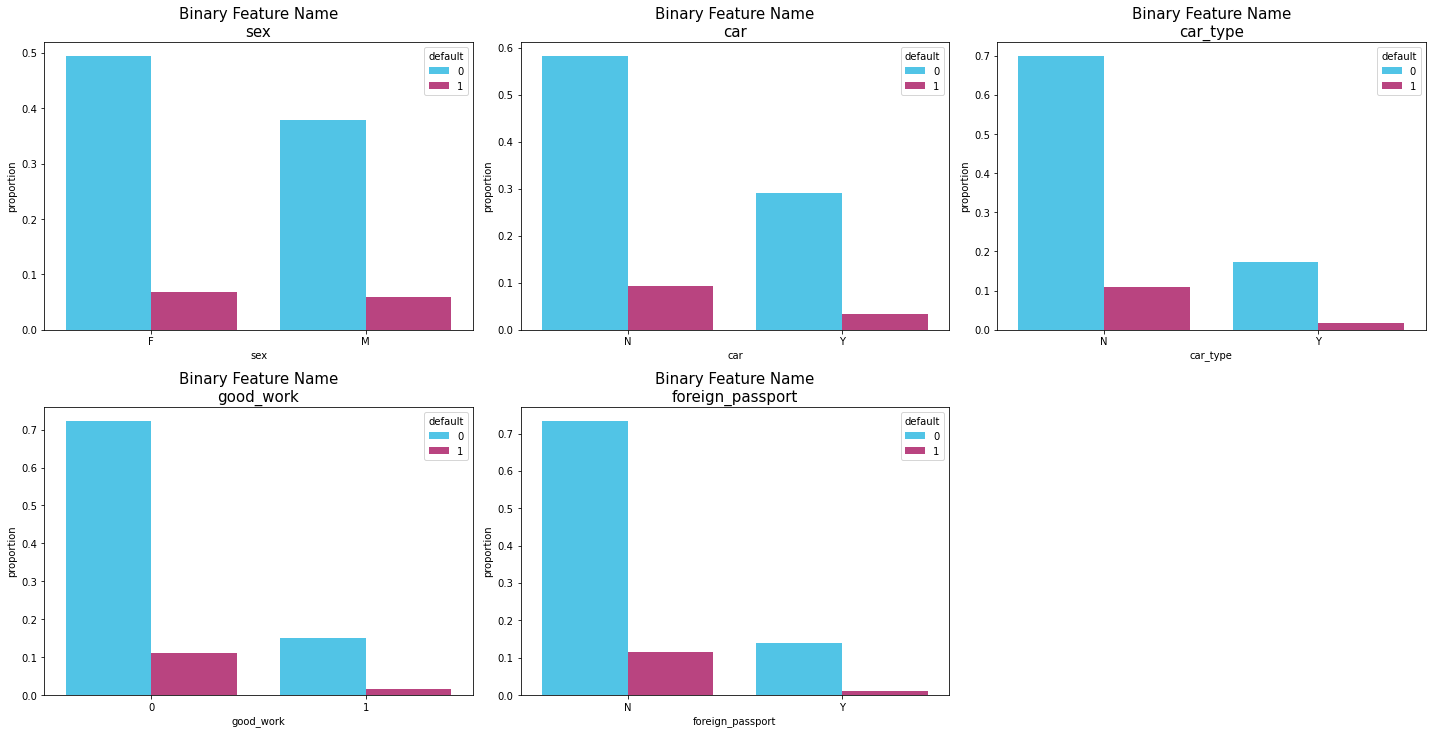

In [26]:
plt.figure(figsize=[20, 20])
i = 1

for k in bool_cols:
    plt.subplot(4, 3, i)
    sns.barplot(x=k,
                y='proportion',
                hue='default',
                data=df_train[[k, 'default']].value_counts(
                    normalize=True).rename('proportion').reset_index(),
                palette=[colors[3], colors[4]])
    plt.title('Binary Feature Name\n' + k, fontsize=15)
    i += 1
plt.tight_layout()
plt.show()

---
By looking at plots, we may note that female borrowers tend to be default slightly more than males.

Borrowers, who has a car could be considered as more reliable.Borrowers who do not have a car tend not to repay their loans twice as often as those who have a car.

Those borrowers who have a car and that car is made abroad,tend to be more reliable. However, if we want to see the distribution more clear, we need to create a new category in this col: Has a domestic car, has a foreign car, has no car.

People, who have good jobs and foreign passport tend to return loans more often than those, who have bad jobs.

---

Let's check the how our features statistically significant?
To do so, we need to encode it to binary entities.

In [27]:
# create an instance of  class
encoder = Preprocessing(df_train)

In [28]:
for col in bool_cols:
    encoder.label_encoder(col)

df_train.sample(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
50075,65317,14MAR2014,GRD,0,30,0,0,1,0,-1.809954,6,50,2,3,26000,1,4,0,0,1
42123,37303,13FEB2014,SCH,0,52,0,0,0,0,-2.129181,3,50,1,2,24000,2,4,0,0,1
599,22476,29JAN2014,SCH,1,57,0,0,1,0,-1.456476,0,40,1,1,20000,1,4,0,0,1


<AxesSubplot:>

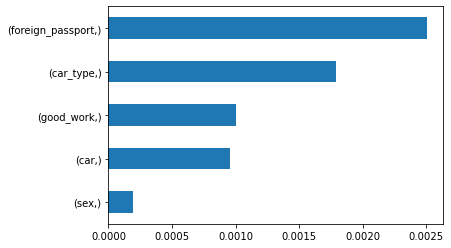

In [29]:
imp_bol = pd.Series(mutual_info_classif(df_train[bool_cols], df_train['default'],
                                        discrete_features=True), index=[bool_cols])
imp_bol.sort_values(inplace=True)
imp_bol.plot(kind='barh')

Well, most significant feature to client's default is ***foreign_passport*** and ***car_type***

Now, get a look into a correlation matrix.

Rank of Matrix: 5
Determinant of matrix: 0.4583
Shape of matrix: (5, 5)


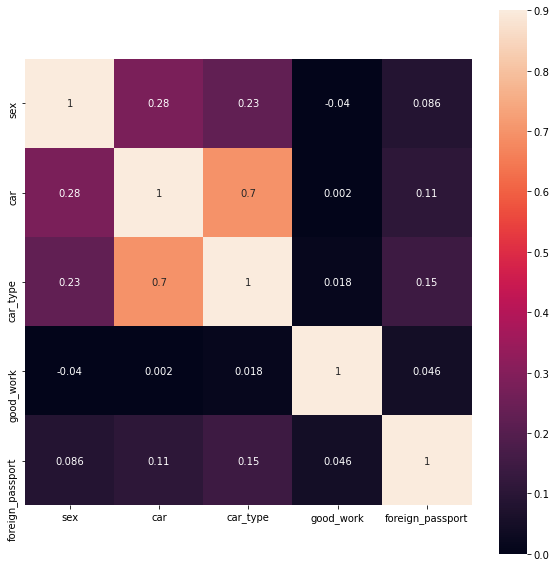

In [30]:
corr_matrix(df_train[bool_cols])

---

We have strong correlation between car and car_type. This can be explained by the fact that the column car indicates the presence of a car, and in the column car_type the presence of a foreign car, however, the absence of a car or whether the car is domestic is not indicated in car_type. In feature engineering section we will combine information from these to columns into a one. It allows us reduce matrix of features without loosing information.

In addition, car is correlated with sex a bit.

---

<a id="sec6.2"></a>
## [6.2 Categorical Feature analysis](#sec6.2)
[(INDEX)](#sec2)

Before we do, let's fill missing values up

In [31]:
# fill up missing vlues
missing_vars(df_train)

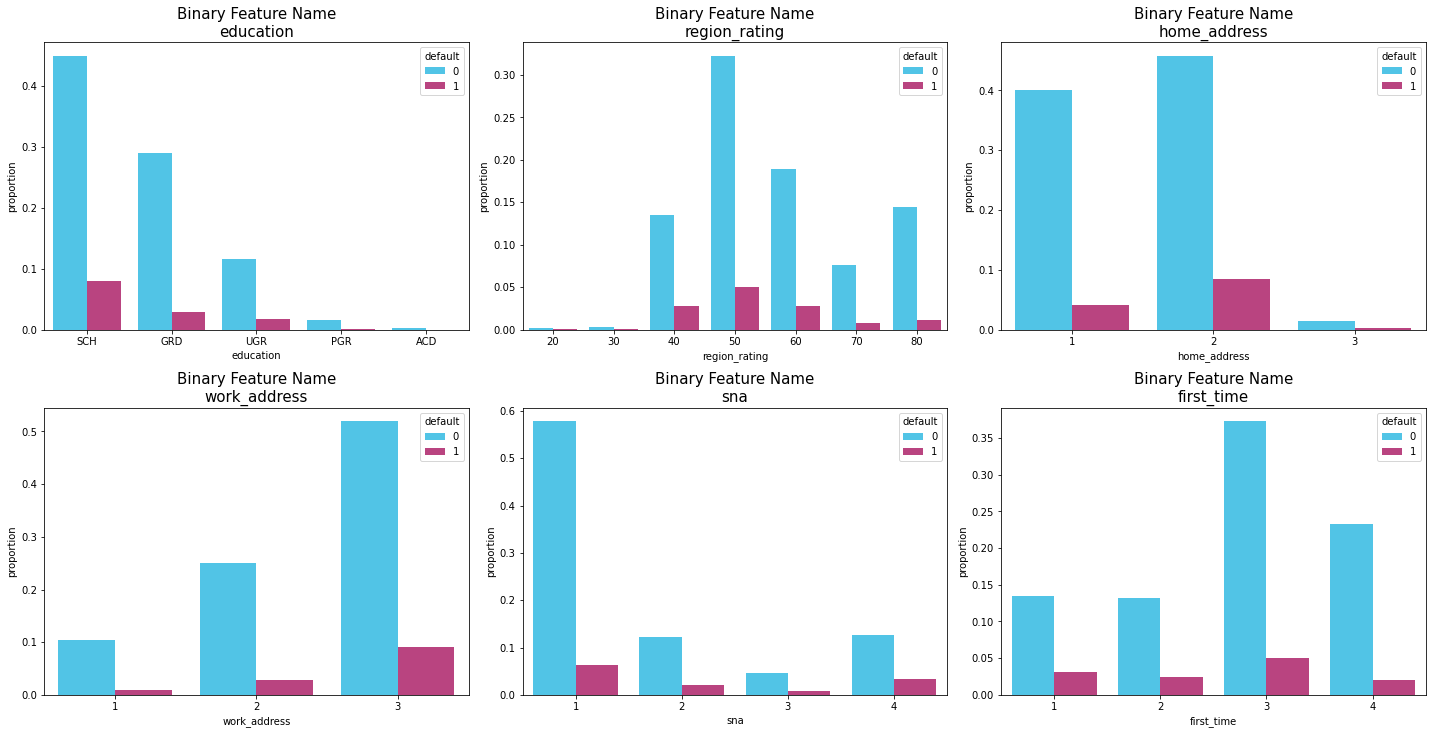

In [32]:
plt.figure(figsize=[20, 20])
i = 1

for k in cat_cols:
    plt.subplot(4, 3, i)
    sns.barplot(x=k, y='proportion', hue='default',  data=df_train[[
                k, 'default']].value_counts(normalize=True).rename('proportion').reset_index(), palette=[colors[3], colors[4]])
    plt.title('Binary Feature Name\n' + k, fontsize=15)
    i += 1
plt.tight_layout()
plt.show()

---

In plots we can see that people with low-grade education fail to return loans more often than people with high-grade education. But in other hand, they borrow more oftenly.

The feature ***region_rating*** gives an interesting insight. The lower rating of the region, the higher share of overdue loan payments. Except two low grade. Perhaps it is some industrial regions.

***Home address*** and ***work addres*** are almost the same. We just can see that share of failed borrowers different from each address. Probably, it has some insights. We will check later.

The category 4 in ***sna*** feature has a higher ratio of failed borrowers. And it falls by reducing the category from 4 to 1.

***First time*** columns also shows us the fall of share of failed borrowers.

---

Let's see, how the region rating depends on education

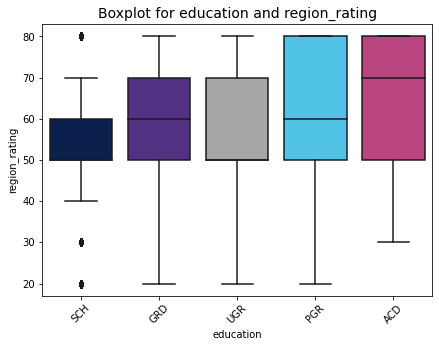

In [33]:
get_boxplot(df_train, 'education', 'region_rating')

People with high level of education prefer to live in a region with higher levels and vice versa.

OK, and now let's see the distribution of the failed borrowers by ***region_rating***

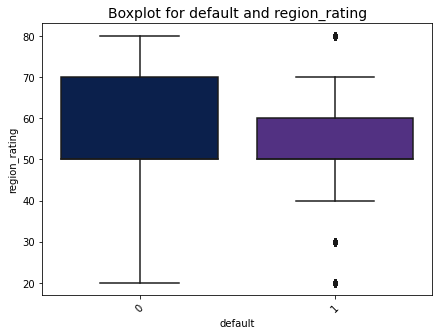

In [34]:
get_boxplot(df_train, 'default', 'region_rating')

---

We may see that default clients lives in mid level regions. The higher rating of the city, the lower the chance to meet a bad guy (default one). It must be a good insight for a model.

---

It's interesting, are we able to observe some relationships between education level and the connection of borrowers with another clients of a bank? Let's see that.

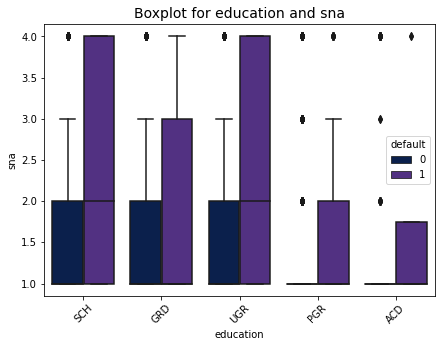

In [35]:
get_boxplot(df_train, 'education', 'sna', hue='default')

---

Well, definatelly we are.
People, mostly with a low level of education, have some kind of relationships with the bank's clients. Perhaps this can be explained by the fact that people with low education grade are working in large teams (factories, plants) and the exchange of information is better, **or** people with higher education do not need guarantors.

---

Check the significance and correlation

In [36]:
# Encode categorical column for better interpretation of results.
for col in cat_cols:
    encoder.label_encoder(col)

<AxesSubplot:>

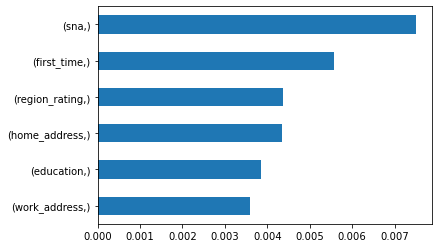

In [37]:
imp_cat = pd.Series(mutual_info_classif(df_train[cat_cols], df_train['default'],
                                        discrete_features=True), index=[cat_cols])
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Rank of Matrix: 6
Determinant of matrix: 0.3003
Shape of matrix: (6, 6)


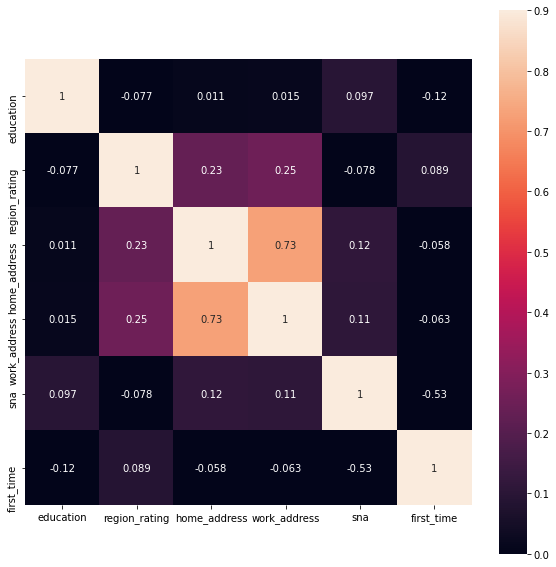

In [38]:
corr_matrix(df_train[cat_cols])

---

We have quite stong correlation between ***sna*** and ***first_time***. Also, these two columns has best significance to a target variable. We may guess, that these two features can be explained as follows: This person has long been a client of the bank and, as a result, has acquired connections with other clients (possibly guarantors ).

Home and work addresses also correlated. We need to think what can we do with these features.

---

<a id="sec6.3"></a>
## [6.3 Numerical Feature analysis](#sec6.3)
[(INDEX)](#sec2)

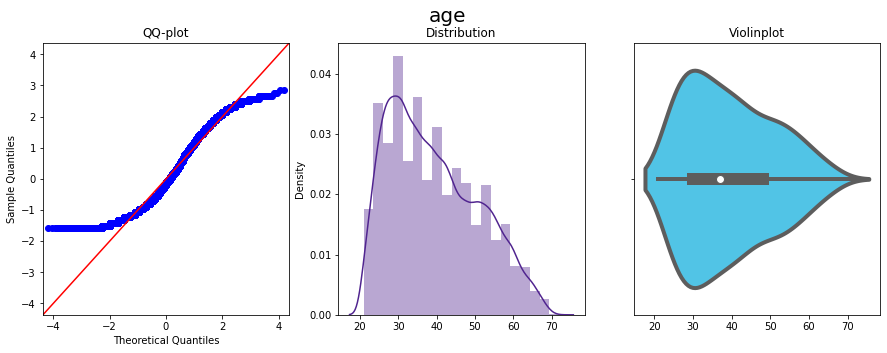

Lower Bound: 3.0, Upper Bound 75.0, Outliers Count: 0


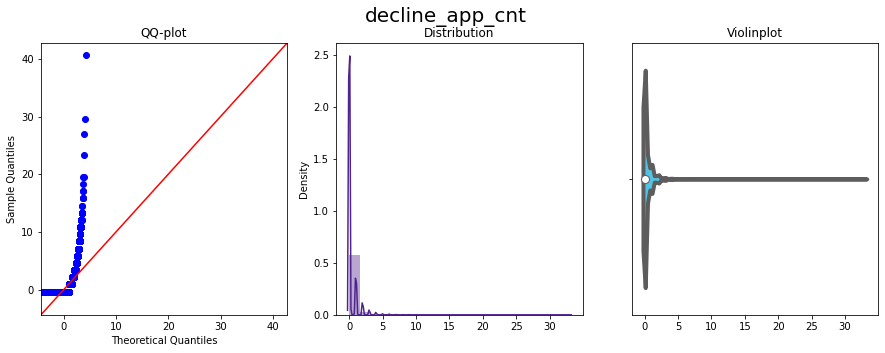

Lower Bound: 0.0, Upper Bound 0.0, Outliers Count: 12585


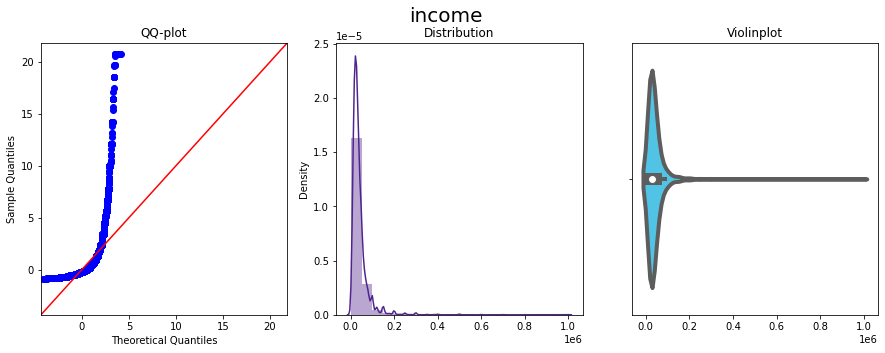

Lower Bound: -22000.0, Upper Bound 90000.0, Outliers Count: 4695


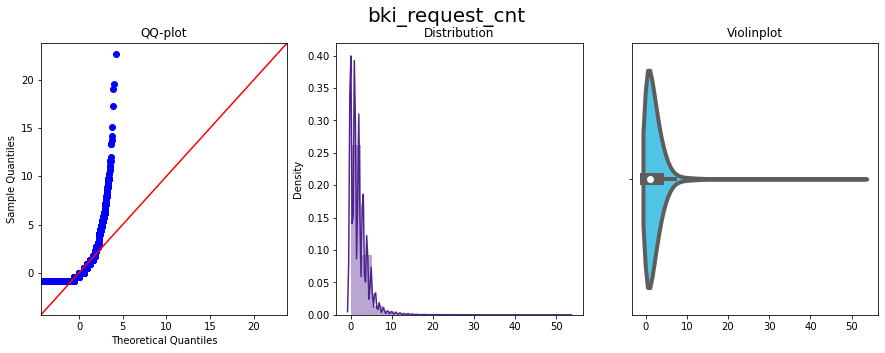

Lower Bound: -4.5, Upper Bound 7.5, Outliers Count: 1755


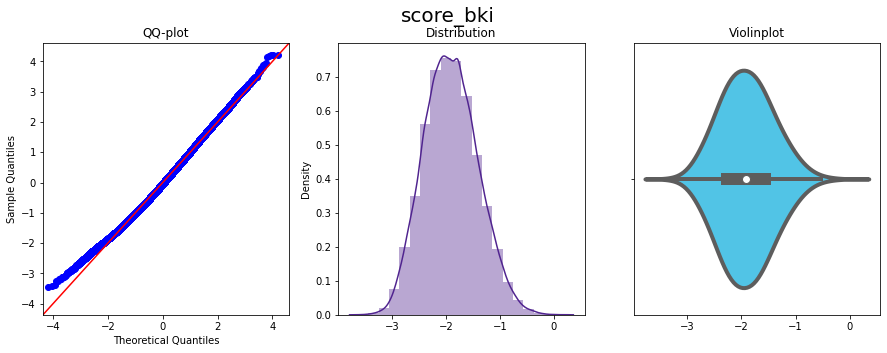

Lower Bound: -3.294, Upper Bound -0.535, Outliers Count: 351


In [39]:
for col in num_cols:
    get_num_info(df_train[col], title=col)
    detect_outliers(df_train[col])

---

Looking at QQ plots, we may note, that only column **score_bki** has a distribution close to normal. Moreover, as was mentioned above, seems this feature already scaled. **Age** has left-biased distribution. Data has outliers, but later we will decide what to do with it.

We have several options: 1. Apply logarithm function do data, 2convert some data to categorical features, Apply combination of logarithm and converting to categorical features.

---

Check a significance of features

<AxesSubplot:>

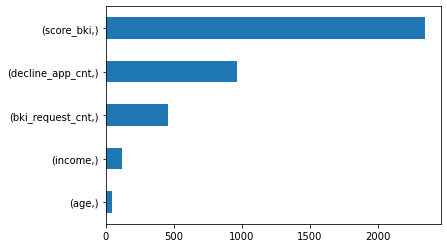

In [40]:
imp_num = pd.Series(f_classif(df_train[num_cols], df_train['default'])[
                    0], index=[num_cols])
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Rank of Matrix: 5
Determinant of matrix: 0.8922
Shape of matrix: (5, 5)


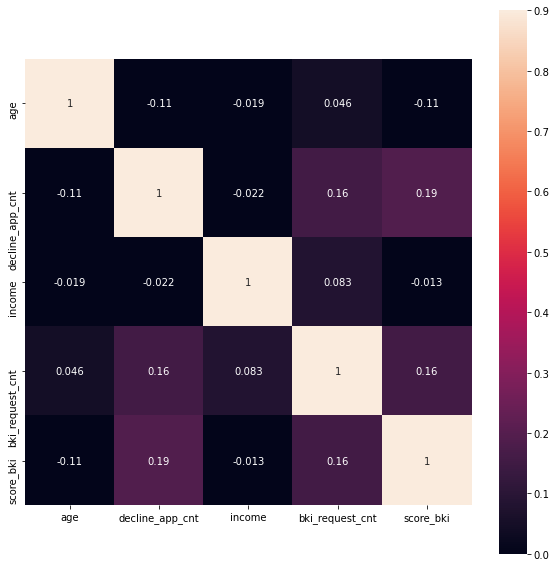

In [41]:
corr_matrix(df_train[num_cols])

---

Most statistically significant variables are **Score_bki**, **decline_app_cnt**. There is no strong correlations between features. It is confirmed by rank of matrix. The value of determinant is good, there must be an inverse matrix.

---

<a id="sec6.4"></a>
## [6.4 Date_Time analysis](#sec6.4)
[(INDEX)](#sec2)

In [42]:
df_train['app_date'] = pd.to_datetime(
    df_train['app_date'])  # convert to  datetime

df_train['days_numb'] = df_train['app_date'].apply(
    lambda x: (get_days_count(x)))  # Number of day in year
df_train['days_beetwen'] = df_train['app_date'].apply(
    lambda x: (get_days_beetwen(x)
               ))  # Number of days between application and current date
df_train['month'] = df_train['app_date'].apply(lambda x: (month(x)))

In [43]:
# Drop app_date
df_train = df_train.drop('app_date', axis=1)

In [44]:
df_train['month'].value_counts()

3    21178
2    18028
4    17683
1    16910
Name: month, dtype: int64

Well, our dataset has only four (4) monts.

Let's see is there any relationships between target data and dates.

In [45]:
# Add cols with dates to existing list of dedicated cols
num_cols = num_cols + ['days_beetwen'] + ['days_numb']
cat_cols = cat_cols + ['month']

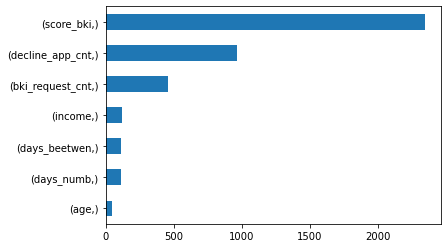

In [46]:
imp_num = pd.Series(f_classif(df_train[num_cols], df_train['default'])[0],
                    index=[num_cols])
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh');

Added feature **days_beetwen** has no significant impact. However it has more than age. Keep this feature.

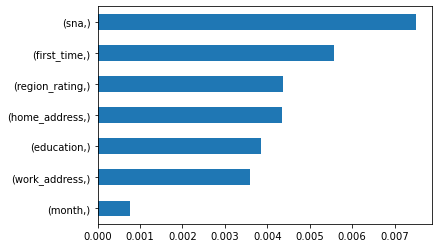

In [47]:
imp_cat = pd.Series(mutual_info_classif(df_train[cat_cols],
                                        df_train['default'],
                                        discrete_features=True),
                    index=[cat_cols])
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh');

Rank of Matrix: 7
Determinant of matrix: 0.2892
Shape of matrix: (7, 7)


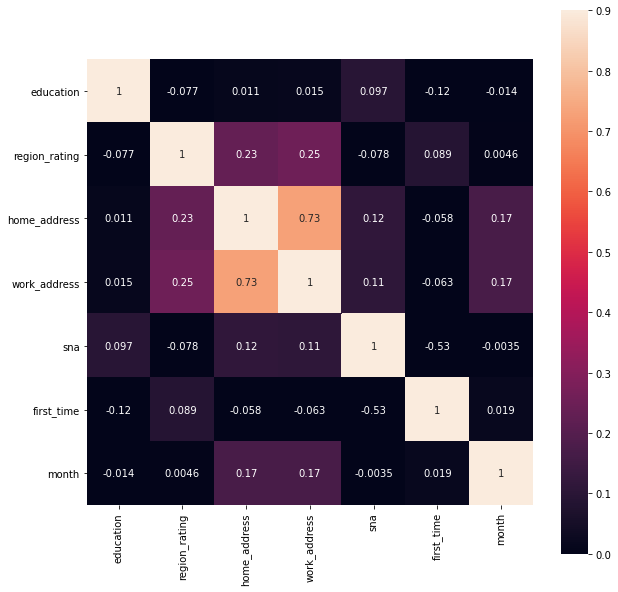

In [48]:
corr_matrix(df_train[cat_cols])

---

Feature **Month** has lower statistic significance. Somehow the month is correlated with work_address. 

Probably, in this period of time larger proportion of people came to bank from specific region.

---

Let's see full correlation matrix

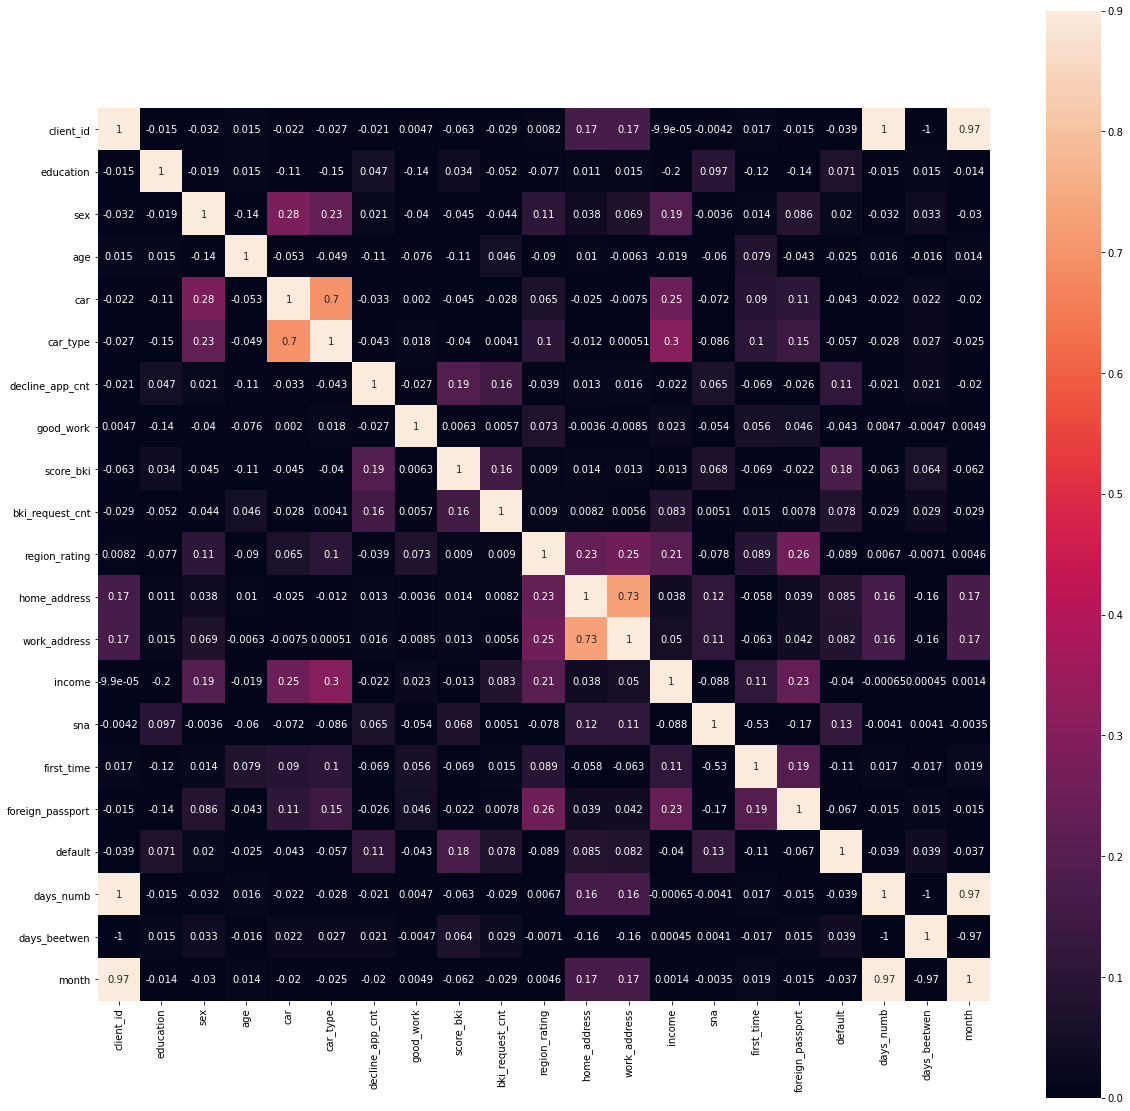

In [49]:
corr_matrix(df_train.drop(['sample'], axis=1), det=False, pltx=20, plty=20)

---

We can see the complete correlation of the **client_id** and **days_numb** features (the ordinal number of the day in the year). This indicates a certain system of assigning a customer number. Most likely, these signs will give us anything useful.

***car_type*** has correlation with income. It can be explained by assumption that if borrower has more income and as a result he has better car and vice versa.

***sna*** has quite strong correlation with ***foreign_passport***

---


<a id="sec6.5"></a>
## [6.5 Draw a conclusion](#sec6.5)
[(INDEX)](#sec2)

---

**Binary:**

 - ***Car*** and ***car_type*** strongly correlated.

 - The column ***car*** indicates the presence of a car, and in the column ***car_type*** the presence of a foreign car. Combine them further

 - Quantity of male and female default borrowers almost the same. However, female tend to loan money more oftenly.

**Category:**

 - People with low-grade education fail to return loans more often than people with high-grade education.

 - More relationships of borrower with another clients - more overduie payments. Feature ***has no guarantors*** can be added to people with high-level education

 - People with high level of education prefer to live in a region with higher level

 - The higher rating of the city, the lower chance of default

 - Correlation between ***sna*** and ***first_time***, ***Home*** and ***work addresses***.
 
**Numerical:**

 - ***score_bki*** has a distribution close to normal. It is already scaled by STD (most likely)
 
 - Data has outliers. However, it is better to convert some features into a categorical type
 
 - There are no strong correlations between features
 
 - ***car_type*** has correlation with income
 
 - ***sna*** has quite strong correlation with ***foreign_passport***
 
 
***Statistically most significant:***

 - foreign_passport

 - car_type

 - sna

 - first_time

 - region_rating
 
 - Score_bki 
 
 - decline_app_cnt.
 
As we have lot's of no obvious correlation and connection between features, it is better to use ***descicion tree models, or logistic regressions.***

---

<a id="sec7"></a>
# [7. Naive Model](#sec7)
[(INDEX)](#sec2)

<img src = 'https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fferriermath.weebly.com%2Fuploads%2F1%2F3%2F8%2F2%2F13820853%2Ffirst-attempt-at-learning_1_orig.jpg&f=1&nofb=1' width = '400px' >

Let's start with Logistic Regression.
Build a naive model to check what we have and what can we do. Also, creation of naive model helps us to evaluate metrics after we improve or modify dataset.

In [50]:
# Split dataset
X_n = df_train.drop(['default'], axis=1)
y_n = df_train['default']

# Build train and test sets

X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n,
                                                    y_n,
                                                    test_size=.2,
                                                    random_state=RANDOM_SEED)

In [51]:
lr = LogisticRegression()
lr.fit(X_train_n, y_train_n)
y_pred = lr.predict(X_test_n)
cf_matrix = confusion_matrix(y_test_n, y_pred)

In [52]:
categories = ['Regular guy', 'DEFAULT']

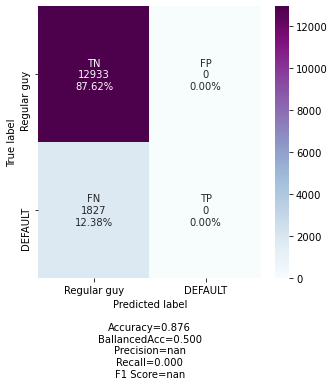

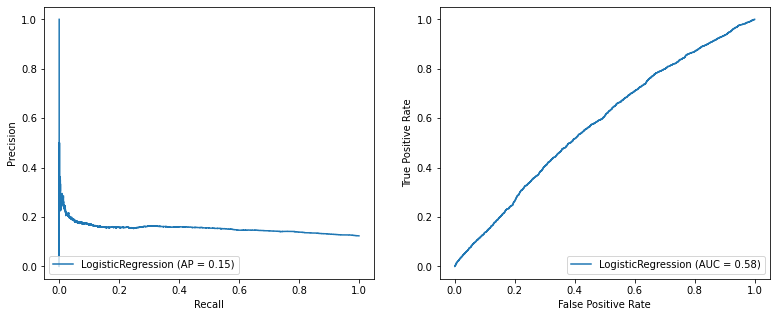

In [53]:
# make confusion matrix
make_confusion_matrix(cf_matrix,categories=categories,sum_stats=True)
# make roc-auc curves
make_roc_auc(lr,X_test_n,y_test_n)

In [54]:
f1_1 = f1_score(y_test_n,y_pred)
print(f1_1)

0.0


---

We can see that our accuracy is about 88% Cool. Let's submit our prediction...

Actually it is a bit early to make such decision. Accuracy depends on how many correct classifications our model made. But, our dataset is not balanced, and we are able to classify only negative class (client's who would return loan) and we are not able to predict default clients for reason that our model learned only negitive classes. 


With a reference to a business target, we have to classify positive class, so then we need to take care about Precision and Recall. 

F1 score is 0.

Area under Curve (AUC) is 0.58. Although, in the ideal case, the value should tend to 1.

Precision-Recall Area is very low.

Well, let's try to improve results. We will do some feature engineering in the next section.

---



<a id="sec8"></a>
# [8. Feature Engineering](#sec8)
[(INDEX)](#sec2)

<img src = 'https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fbestvacuumresource.com%2Fwp-content%2Fuploads%2FRobot-Holding-Vacuum-Cleaner.jpg&f=1&nofb=1' width = '400px' >

We will work with combined dataset (Train and validation). Before modeling we split them out.

<a id="sec8.1"></a>
## [8.1 Create New features](#sec8.1)
[(INDEX)](#sec2)

### [CAR_CAR_TYPE]

In [55]:
# fill up missing vars
missing_vars(df)

# Drop client_id
df = df.drop(['client_id'], axis=1)

# Encode binary features
encoder = Preprocessing(df)
for i in list(['car', 'car_type']):
    encoder.label_encoder(i)
    
# reduce size. Combine car and car_type. Encode it.
# 0 - Has no car, 1-Has semi-car (Zhiguli), 3- has a car
df['car_comb'] = df['car'] + df['car_type']
df = df.drop(['car', 'car_type'], axis=1)
df['car_comb'] = df['car_comb'].astype('category')

In [56]:
df.sample(3)

,app_date,education,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,car_comb
30246,10MAR2014,SCH,F,35,2,0,-1.696475,11,40,2,3,30000,4,3,N,0,NaN,0
108846,24MAR2014,SCH,M,32,4,0,-1.346201,3,50,3,3,50000,1,3,N,1,0.0,2
23332,18JAN2014,GRD,F,33,0,0,-2.068570,0,60,1,2,18000,1,4,N,0,NaN,0


### [AGE TO CATEGORICAL]

In [57]:
# age
# Devide age into categories: young,'not-young','midle','oldfag'
def age_to_cat(age):
    if age <= 28:
        cat_age = 'young'
        return cat_age             
    if 28 < age <= 35:
        cat_age = 'not-young'
        return cat_age
    if 35 < age <= 50:
        cat_age = 'midle'
        return cat_age
    if age > 50:
        cat_age = 'oldfag'
        return cat_age

In [58]:
df['age_cat'] = 0 # create age_categorical column
df['age_cat'] = df['age'].apply(lambda x:age_to_cat(x))
df = df.drop('age',axis=1)

In [59]:
df.sample(3)

,app_date,education,sex,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,car_comb,age_cat
37074,11JAN2014,SCH,M,0,0,-2.186115,0,40,1,2,10000,1,4,N,1,0.0,0,oldfag
1879,28MAR2014,SCH,F,0,0,-1.375149,2,50,1,2,27000,1,3,N,0,NaN,1,midle
92117,10FEB2014,GRD,M,0,0,-1.443544,6,50,1,2,30000,1,2,Y,1,1.0,0,young


midle        38960
not-young    26265
young        22823
oldfag       22100
Name: age_cat, dtype: int64

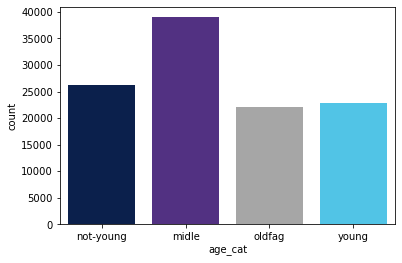

In [60]:
# Check age distribution
sns.countplot(df['age_cat'],palette=colors)
df['age_cat'].value_counts()

---

Well, we can see that our dataset has more people with middle age. Nothing is strange

---

### [DECLINE & bki_request count TO CATEGORICAL]

Sort out **decline_app_cnt** and ***bki_request_cnt***  by groups:

In [61]:
df['decline_cat'] = df['decline_app_cnt'].apply(lambda x: 4 if x >= 4 else x) 

df['bki_request_cat'] = df['bki_request_cnt'].apply(lambda x: 7 if x >= 7 else x) # option 1
df = df.drop('decline_app_cnt',axis=1)
df = df.drop('bki_request_cnt',axis=1)

### [DECOMPOSITION]

As we remember, in DATA analysis we found, that ***home_address*** and ***work address*** are correlated (.7). Do vector space reducion using sklearn.decomposition module. Lets try principal component analyse method.

In [62]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# extract two columns from dataset
data = df[['work_address', 'home_address']].values

# create Scaler instance
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# We have two vectors. Reduce plane to line, taking most important info.
pca = PCA(n_components=1)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
df['pca_address'] = pca_data

# drop used columns
df = df.drop(['home_address','work_address'],axis=1)

### [DATES]

Proceed with date columns.

In [63]:
 # convert yo datetime
df['app_date'] = pd.to_datetime(
    df['app_date'])

 # Num of days between application and current date
df['days_beetwen'] = df['app_date'].apply(
    lambda x: (get_days_beetwen(x)
               ))

# Extract month
df['month'] = df['app_date'].apply(lambda x: (month(x)))
df = df.drop('app_date', axis=1)

### [Guarantors]

With a reference to EDA section we made assumption, that people with high degree don't need to have guarantors.Let's add new feature - has no guarantors.

In [64]:
def has_no_garant(edu, grnt):
    if edu == 'PGR' or edu == 'ACD':
        grnt = 1
        return grnt
    else:
        grnt = 0
        return grnt

In [65]:
df['has_no_guarantor'] = 0
df['has_no_guarantor'] = df[['education', 'has_no_guarantor']].apply(
    lambda x: has_no_garant(*x), axis=1)

In [66]:
df.sample(3)

,education,sex,good_work,score_bki,region_rating,income,sna,first_time,foreign_passport,sample,default,car_comb,age_cat,decline_cat,bki_request_cat,pca_address,days_beetwen,month,has_no_guarantor
54340,SCH,M,0,-1.646915,50,23000,4,1,N,1,1.0,0,not-young,1,3,1.086059,2572,4,0
9350,SCH,M,0,-2.104211,60,18000,1,2,N,0,NaN,0,midle,0,0,-1.282573,2628,2,0
100425,SCH,M,1,-1.628413,50,28237,1,3,N,1,1.0,1,midle,0,2,1.086059,2571,4,0


Let's save a copy of df with current processing. We need to use that copy for gradient boosting later on this Notebook

In [67]:
# Let's save a dataset for boosting models
df_boost = df.copy()

<a id="sec8.2"></a>
## [8.2 ENCODING](#sec8.2)
[(INDEX)](#sec2)

In [68]:
# instance of preprocessing class
encoder = Preprocessing(df)

Firstly, we use label encoder to convert binary features

In [69]:
# label Encoder
for i in list(['sex', 'foreign_passport', 'good_work', 'has_no_guarantor']):
    encoder.label_encoder(i)

And use One_hot encoder to convert categorical features

In [70]:
cols_to_hot = ['education','region_rating',
               'sna','first_time','car_comb',
               'decline_cat','bki_request_cat',
              'month','age_cat'] 

for col in cols_to_hot:
    df = encoder.hot_enc(col)

<a id="sec8.3"></a>
## [8.3 LOGARITHM](#sec8.3)
[(INDEX)](#sec2)

In [71]:
# to avoid infinite or none val, let's add 5 to column
df['pca_address'] = df['pca_address'] + 5

cols_to_log = ['days_beetwen','pca_address','income']

In [72]:
for col in cols_to_log:
    df[col] = df[col].apply(lambda x: np.log(x) +1)

In [73]:
df.sample(3)

,sex,good_work,score_bki,income,foreign_passport,sample,default,pca_address,days_beetwen,has_no_guarantor,...,hot_bki_request_cat_6,hot_bki_request_cat_7,hot_month_1,hot_month_2,hot_month_3,hot_month_4,hot_age_cat_midle,hot_age_cat_not-young,hot_age_cat_oldfag,hot_age_cat_young
6573,1,0,-1.428354,11.596635,0,0,NaN,2.806001,8.881560,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20633,1,0,-2.169664,10.798127,0,0,NaN,2.806001,8.865572,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
24115,1,0,-1.911663,11.308953,0,0,NaN,2.806001,8.846199,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


<a id="sec8.3"></a>
## [8.4 Feature Scaling](#sec8.4)
[(INDEX)](#sec2)

In [74]:
# Extract the part of dataframe for testing
df_train = df.query('sample == 1').drop(['sample'], axis=1)
df_valid = df.query('sample == 0').drop(['sample'], axis=1)

# Extract data and label
X = df_train.drop(['default'], axis=1)
y = df_train[['default']]

# Extract data for validation
X_valid = df_valid.drop(['default'], axis=1)

In [75]:
scaler = RobustScaler()
cols_to_scal = ['income', 'days_beetwen', 'pca_address']

X[cols_to_scal] = scaler.fit_transform(X[cols_to_scal])
X_valid[cols_to_scal] = scaler.transform(X_valid[cols_to_scal])

In [76]:
print(
    f'Shape of X_train:{X.shape} \nShape of X_Valid:{X_valid.shape} \nShape of Target:{y.shape} '
)

Shape of X_train:(73799, 52) 
Shape of X_Valid:(36349, 52) 
Shape of Target:(73799, 1) 


<a id="sec9"></a>
# [9. Models](#sec9)
[(INDEX)](#sec2)

<a id="sec9.1"></a>
## [9.1 LOG REGRESSION (naive)](#sec9.1)

Split our train data into two parts: Train and test

In [77]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, random_state=RANDOM_SEED)

In [78]:
# Build a model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# make a prediction
y_pred = lr.predict(X_test)

# Make a confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

In [79]:
# Set names for confusion matrix
categories = ['Regular guy', 'DEFAULT']

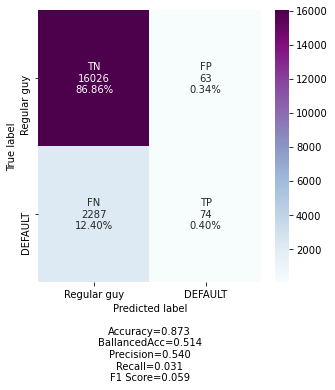

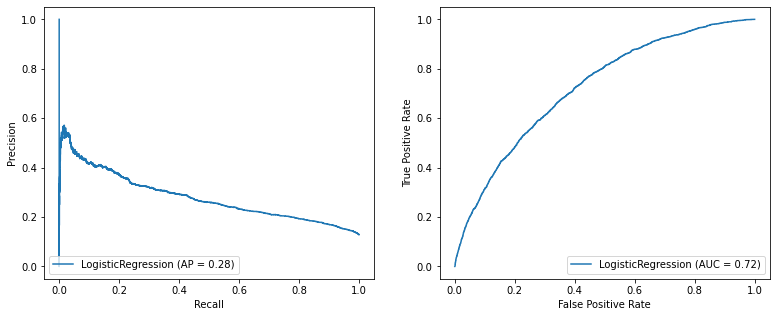

In [80]:
# Plot confusion matrix
make_confusion_matrix(cf_matrix,categories=categories,sum_stats=True)
# Plot ROC-AUC curves
make_roc_auc(lr,X_test,y_test)

Let's create a table where we can save the computation results

In [81]:
df_report = pd.DataFrame(data=None)

In [82]:
df_report = get_scores(df_report, lr, X_test,
                       y_test, 'LogisticRegression_Naive')

In [83]:
df_report

,ROC-AUC,PR-AUC,F1,precision_Neg,precision_Pos,recall_Neg,recall_Pos
LogisticRegression_Naive,0.723989,0.540146,0.059247,0.875116,0.540146,0.996084,0.031343


---

True-positive - Is correctly classified as default client

False positive - Not default clients incorrectly classified as default

False Negative - Default clients incorectly classified as not default(regular guy)


As ROC-AUC is not good to apply when classes disballanced, let's check Precision-Recall curve. **Only PRC changes with the ratio of positives and negatives**.  (first pic.)
#### Link :  **[The Precision-Recall Plot Is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432)**.

PR-REC AUC is close to (0.5),f1_score also extreamely low(0.05) which means that the algorithm is not yet able to distinguish between classes in any way, most of all it assigns class 0 (Not Default) to objects, we will try to choose the best parameters, and also we will make a stratification, which is often used when class disbalanced.

As our Business target is to identify positive class ( Default Client), then we need to look at sensitivity metric (recall). In other words, check the proportion of default clients were correctly classified

It is only 0.03 now.

---


<a id="sec9.2"></a>
## [9.2 LOG REGRESSION (CrosValid & GridSearch)](#sec9.2)
[(INDEX)](#sec2)

Let's try to fit our model with best parameters and check results by Cross-Validation using sklearn modul StratifieldShuffleSplit.

It can give us more correct metrics due to splitting our dataset by more than just two sets. In this case, the data inside may be more balanced. Also, it may help us to avoid overfitting.

Overfiting - a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data

In [84]:
# class weigh - ballanced is to compensate unbalanced data
lr_skf = LogisticRegression(class_weight='balanced')
skf = StratifiedShuffleSplit(n_splits=6, random_state=RANDOM_SEED)

param = {'C': np.linspace(0.001, 10, 10), 'penalty': ['l1', 'l2']}

# refit - True. Use best parameter when predicting
clf_lr = GridSearchCV(
    lr_skf, param, scoring='roc_auc', refit=True, cv=skf)
clf_lr.fit(X_train, y_train)

y_pred = clf_lr.predict(X_test)
cf_matrix = confusion_matrix(y_test,y_pred)

print('Best roc_auc: {:.4}, with best C: {}'.format(
    clf_lr.best_score_, clf_lr.best_params_))

Best roc_auc: 0.737, with best C: {'C': 10.0, 'penalty': 'l2'}


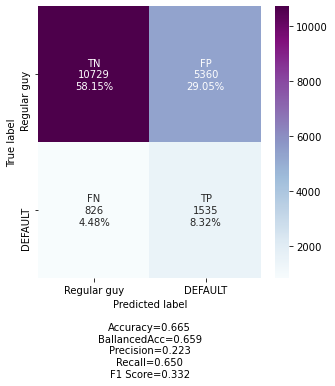

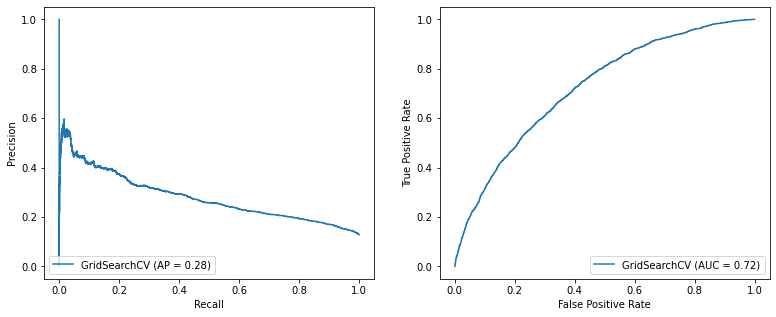

In [85]:
# Plot confusion matrix
make_confusion_matrix(cf_matrix,categories=categories,sum_stats=True)

# Plot ROC-AUC curves
make_roc_auc(clf_lr,X_test,y_test)

In [86]:
# write down results to our table
df_report = get_scores(df_report, clf_lr, X_test,
                       y_test, 'LogisticRegression_skf')

In [87]:
df_report

,ROC-AUC,PR-AUC,F1,precision_Neg,precision_Pos,recall_Neg,recall_Pos
LogisticRegression_Naive,0.723989,0.540146,0.059247,0.875116,0.540146,0.996084,0.031343
LogisticRegression_skf,0.724010,0.222625,0.331677,0.928516,0.222625,0.666853,0.650148


---

Well, the model started to predict better than before. Sensitivity (recall) is noticebly grown. F1 score also grown. Proportion of positive samples (precision) that were correctly classified dropped. Our model incorrectly classified default clients (FP=28%), while TP is only 8.5%

Sure it is better, but not good enough

Let's try to add objects of the missing class for balancing dataset

---

<a id="sec9.3"></a>
## [9.3 LOG REGRESSION Oversampling](#sec9.3)
[(INDEX)](#sec2)

In this and next section (9.4) we try to balance our datasets using RandomOverSampler.

Let's prepare dataset for oversampling

In [88]:
# For oversampling use whole dataset excluding validation set.
oversample = RandomOverSampler(sampling_strategy=1)
X_, y_ = oversample.fit_resample(X, y)

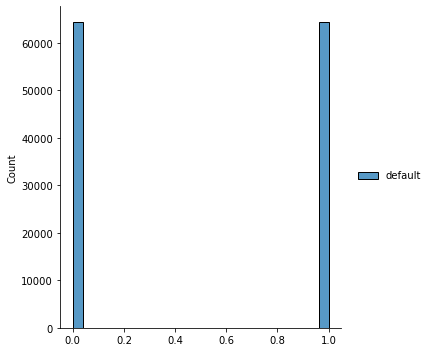

In [89]:
# Plot label distribution
sns.displot(y_);

It is ready for further experiments.

In [90]:
X_over, X_test_ov, y_over, y_test_ov = train_test_split(
    X_, y_, test_size=.2, shuffle=True, random_state=RANDOM_SEED
)

In [91]:
lr_skf_over = LogisticRegression()
skf = StratifiedShuffleSplit(n_splits=5, random_state=RANDOM_SEED)

param = {'C': np.linspace(0.001, 10, 10), 'penalty': ['l1', 'l2']}

# verbose - show system info

clf_lr_over = GridSearchCV(
    lr_skf_over, param, scoring='roc_auc', refit=True, cv=skf, verbose=False)
clf_lr_over.fit(X_over, y_over)

y_pred_skf_over = clf_lr_over.predict(X_test_ov)
cf_matrix = confusion_matrix(y_test_ov, y_pred_skf_over)

print('Best roc_auc: {:.4}, with best C: {}'.format(clf_lr_over.best_score_,
                                                    clf_lr_over.best_params_))

Best roc_auc: 0.7346, with best C: {'C': 10.0, 'penalty': 'l2'}


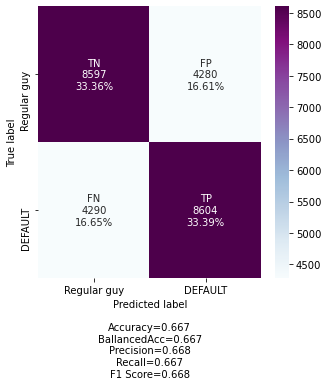

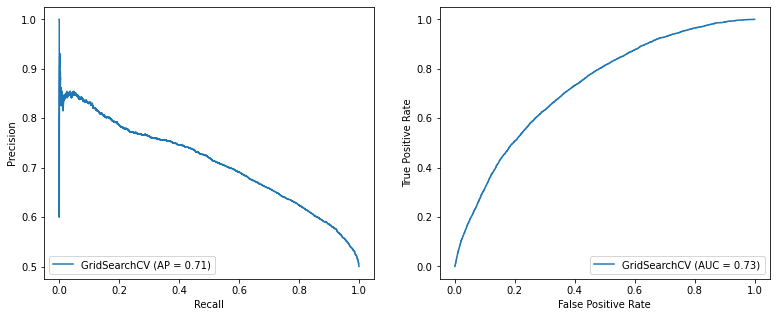

In [92]:
make_confusion_matrix(cf_matrix,categories=categories,sum_stats=True)
make_roc_auc(clf_lr_over,X_test_ov,y_test_ov)

In [93]:
df_report = get_scores(df_report, clf_lr_over, X_test_ov,
                       y_test_ov, 'LogisticRegression_skf_over')

In [94]:
df_report

,ROC-AUC,PR-AUC,F1,precision_Neg,precision_Pos,recall_Neg,recall_Pos
LogisticRegression_Naive,0.723989,0.540146,0.059247,0.875116,0.540146,0.996084,0.031343
LogisticRegression_skf,0.724010,0.222625,0.331677,0.928516,0.222625,0.666853,0.650148
LogisticRegression_skf_over,0.730904,0.667805,0.667546,0.667106,0.667805,0.667624,0.667287


---

As we may see, results are much better. However, due to lack of the data (our dataset presents only 4 month), our model is still not able to classify positive class perfectly.

In this Notebook we will try to find better solution with small amount of data.

Let's check Overfitting of our model and Feature importance.

---

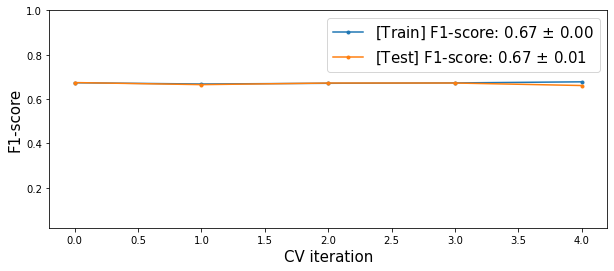

In [95]:
plot_cross_validate(clf_lr_over,
                    X_over,
                    X_test_ov,
                    y_over,
                    y_test_ov,
                    cv=5)

Well, it seems not to be **underfitted**. Model classify objects in the training and test sets more or less good.

The checking of feature importance via permutations within one feature (for example, a line): if after the permutation the model error increased, then the feature is "important", if the error occurred unchanged, then it is "unimportant" 

In [96]:
permutation_imp(clf_lr_over, X_test_ov, y_test_ov, 15)

,feature,weight,std,f
0,score_bki,0.047172,0.001678,2
1,pca_address,0.020407,0.001046,5
2,hot_education_SCH,0.014522,0.001089,11
3,hot_region_rating_80,0.010170,0.000978,19
4,hot_sna_4,0.008518,0.000827,23
5,hot_region_rating_40,0.006747,0.001489,15
6,hot_car_comb_0,0.006679,0.000630,28
7,days_beetwen,0.005761,0.001975,6
8,hot_education_UGR,0.004396,0.000599,12
9,hot_first_time_2,0.004226,0.001097,25


---

Well, Score+bki is most important column for our model. Right after it PCA_address. This column what we created by combination information from two correlated columns work and home address. 

As we suspected, the region rating also important feature. Higher (80)region takes 3d place in importance feature table.

Car_comb also quite important. People without any car somehow impact on the classification.

Will **will not delete** unimportant features. It somehow decreases score for this competition

---

<a id="sec9.4"></a>
## [9.4 LOG REGRESSION Undersampling](#sec9.4)
[(INDEX)](#sec2)

Try to do the same with undersampling

In [97]:
# For undrsampling use whole dataset excluding validation set.
undersample = RandomUnderSampler()
X_u, y_u = undersample.fit_resample(X, y)

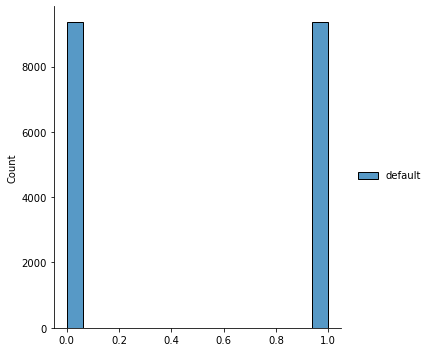

In [98]:
# Plot label distribution
sns.displot(y_u);

In [99]:
X_under, X_test_un, y_under, y_test_un = train_test_split(
    X_u, y_u, test_size=.2, shuffle=True, random_state=RANDOM_SEED
)

In [100]:
lr_skf_under = LogisticRegression()
skf = StratifiedShuffleSplit(n_splits=5, random_state=RANDOM_SEED)

param = {
    'C': np.linspace(0.001, 10, 10),
    'penalty': ['l1', 'l2', 'elasticnet']
}

clf_lr_under = GridSearchCV(lr_skf_under,
                            param,
                            scoring='roc_auc',
                            refit=True,
                            cv=skf,
                            verbose=False)
clf_lr_under.fit(X_under, y_under)

y_pred_skf_under = clf_lr_under.predict(X_test_un)
cf_matrix = confusion_matrix(y_test_un, y_pred_skf_under)

print('Best roc_auc: {:.4}, with best C: {}'.format(clf_lr_under.best_score_,
                                                    clf_lr_under.best_params_))

Best roc_auc: 0.729, with best C: {'C': 4.445, 'penalty': 'l2'}


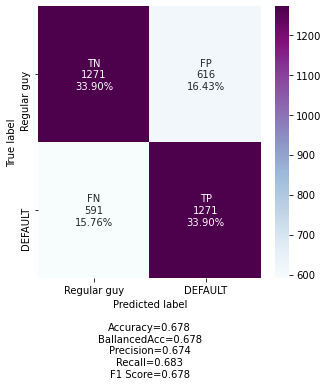

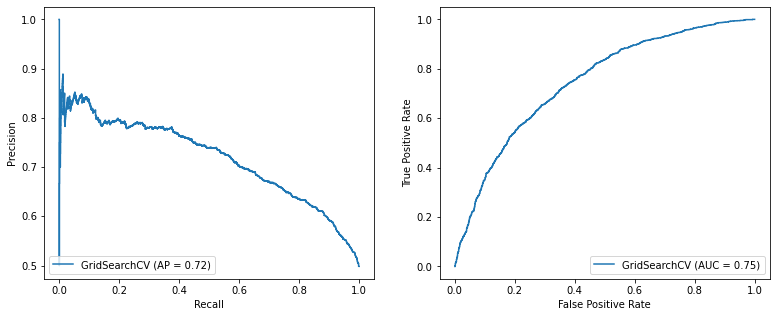

In [101]:
make_confusion_matrix(cf_matrix,categories=categories,sum_stats=True)
make_roc_auc(clf_lr_under,X_test_un,y_test_un)

In [102]:
df_report = get_scores(df_report, clf_lr_under, X_test_un,
                       y_test_un, 'LogisticRegression_skf_under')

In [103]:
df_report

,ROC-AUC,PR-AUC,F1,precision_Neg,precision_Pos,recall_Neg,recall_Pos
LogisticRegression_Naive,0.723989,0.540146,0.059247,0.875116,0.540146,0.996084,0.031343
LogisticRegression_skf,0.724010,0.222625,0.331677,0.928516,0.222625,0.666853,0.650148
LogisticRegression_skf_over,0.730904,0.667805,0.667546,0.667106,0.667805,0.667624,0.667287
LogisticRegression_skf_under,0.746240,0.673556,0.678047,0.682599,0.673556,0.673556,0.682599


---

Well, there is no significant changes. But area under precision-recall curve is bit higher. F1 also looks better. F1 increased because we increaqsed recall_pos, While precision for positive class dropped a little.

Let's try other algorithms

---

<a id="sec9.5"></a>
## [9.5 Random Forest_Naive](#sec9.5)
[(INDEX)](#sec2)

Go Ahead with Naive Random Forest

In [104]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
cf_matrix = confusion_matrix(y_test,y_pred_rf)

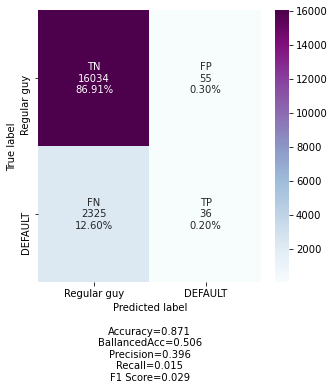

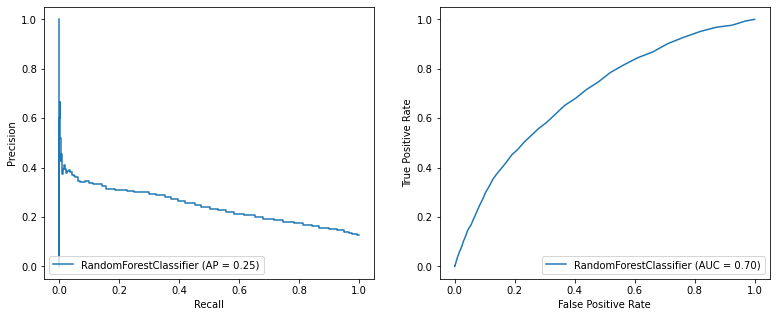

In [105]:
make_confusion_matrix(cf_matrix,categories=categories,sum_stats=True)
make_roc_auc(rf,X_test,y_test)

In [106]:
df_report = get_scores(df_report, rf, X_test, y_test, 'RandomForestClassifier')

In [107]:
df_report

,ROC-AUC,PR-AUC,F1,precision_Neg,precision_Pos,recall_Neg,recall_Pos
LogisticRegression_Naive,0.723989,0.540146,0.059247,0.875116,0.540146,0.996084,0.031343
LogisticRegression_skf,0.724010,0.222625,0.331677,0.928516,0.222625,0.666853,0.650148
LogisticRegression_skf_over,0.730904,0.667805,0.667546,0.667106,0.667805,0.667624,0.667287
LogisticRegression_skf_under,0.746240,0.673556,0.678047,0.682599,0.673556,0.673556,0.682599
RandomForestClassifier,0.695746,0.395604,0.029364,0.873359,0.395604,0.996582,0.015248


Random forest without additionla tunings shows worse results.

<a id="sec9.6"></a>
## [9.6 Random Forest_GridSearch](#sec9.6)
[(INDEX)](#sec2)

Let's try to apply GridSearch of parameters with crossvalidation

In [108]:
# Grid Search
rf_skf = RandomForestClassifier(class_weight='balanced')
skf = StratifiedShuffleSplit(n_splits=5, random_state=42)

param = {
    'bootstrap': [True],
    'max_depth': [10, 30],
    'n_estimators': [600, 1000]
}

clf_rf = GridSearchCV(rf_skf,
                      param,
                      scoring='roc_auc',
                      refit=True,
                      cv=skf,
                      verbose=3,
                      n_jobs=-1)
clf_rf.fit(X_train, y_train)

y_pred_rf_skf = clf_rf.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred_rf_skf)

print('Best roc_auc: {:.4}, with best C: {}'.format(clf_rf.best_score_,
                                                    clf_rf.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:   48.2s remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.3min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:  2.4min remaining:   16.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.4min finished


Best roc_auc: 0.7336, with best C: {'bootstrap': True, 'max_depth': 10, 'n_estimators': 1000}


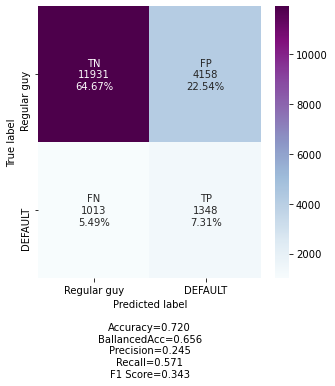

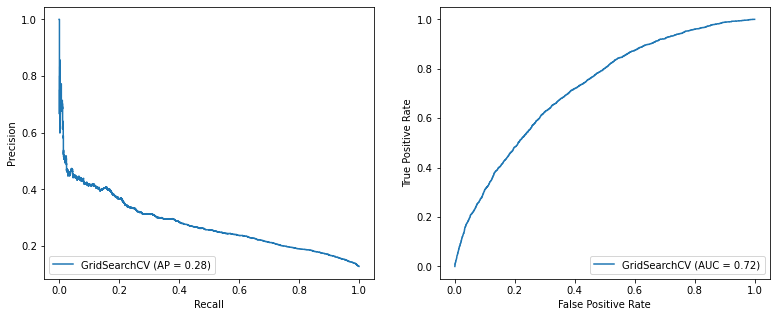

In [109]:
make_confusion_matrix(cf_matrix,categories=categories,sum_stats=True)
make_roc_auc(clf_rf,X_test,y_test)

In [110]:
df_report = get_scores(df_report, clf_rf, X_test, y_test, 'RandomForestClassifier_skf')

In [111]:
df_report

,ROC-AUC,PR-AUC,F1,precision_Neg,precision_Pos,recall_Neg,recall_Pos
LogisticRegression_Naive,0.723989,0.540146,0.059247,0.875116,0.540146,0.996084,0.031343
LogisticRegression_skf,0.724010,0.222625,0.331677,0.928516,0.222625,0.666853,0.650148
LogisticRegression_skf_over,0.730904,0.667805,0.667546,0.667106,0.667805,0.667624,0.667287
LogisticRegression_skf_under,0.746240,0.673556,0.678047,0.682599,0.673556,0.673556,0.682599
RandomForestClassifier,0.695746,0.395604,0.029364,0.873359,0.395604,0.996582,0.015248
RandomForestClassifier_skf,0.722681,0.244824,0.342697,0.921740,0.244824,0.741563,0.570945


Same problem. Unbalanced data. Lack of data and as a result we cannot get good metreics of ROC-AUC and F1, as well as psitive class precision.

However, We got best PR-AUC and best F1 score. It happened because our precicion and recall became a little bit balanced.

<a id="sec9.7"></a>
## [9.7 Random Forest_OverSampling](#sec9.7)
[(INDEX)](#sec2)

Repeat same workflow for RandomFores as we did for LogRegressor with oversampling.

Apply gridSearch for parameters

In [112]:
# Grid Search
rf_skf = RandomForestClassifier()
skf = StratifiedShuffleSplit(n_splits=5, random_state=42)

param = {
    'bootstrap': [True],
    'max_depth': [5, 10], #  depth of the tree
    'n_estimators': [100, 200], # The number of trees in the forest
    'max_features' : [4] # The number of features to consider when looking for the best split
}

clf_rf_over = GridSearchCV(rf_skf,
                           param,
                           scoring='roc_auc',
                           refit=True,
                           cv=skf,
                           verbose=3,
                           n_jobs=-1)
clf_rf_over.fit(X_over, y_over)

y_pred_rf_over = clf_rf_over.predict(X_test_ov)
cf_matrix = confusion_matrix(y_test_ov, y_pred_rf_over)

print('Best roc_auc: {:.4}, with best C: {}'.format(clf_rf_over.best_score_,
                                                    clf_rf_over.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:    7.8s remaining:   31.4s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   15.4s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:   25.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   26.0s finished


Best roc_auc: 0.7784, with best C: {'bootstrap': True, 'max_depth': 10, 'max_features': 4, 'n_estimators': 200}


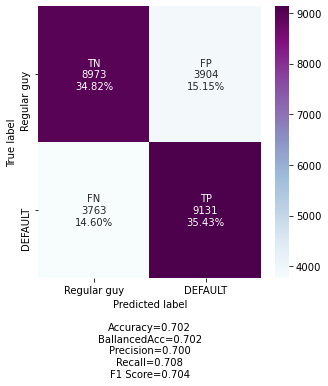

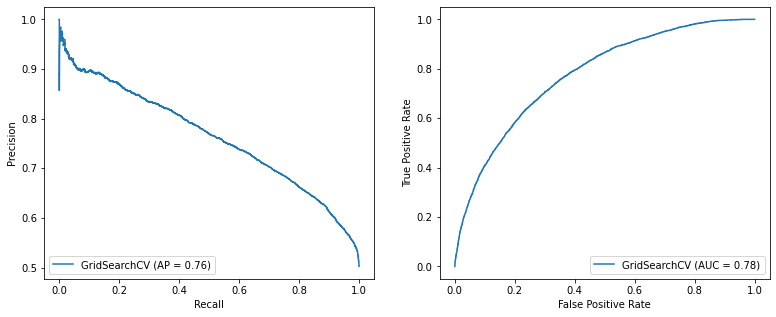

In [113]:
make_confusion_matrix(cf_matrix,categories=categories,sum_stats=True)
make_roc_auc(clf_rf_over,X_test_ov,y_test_ov)

In [114]:
df_report = get_scores(df_report, clf_rf_over, X_test_ov, y_test_ov,
                       'RandomForestClassifier_skf_over')

In [115]:
df_report

,ROC-AUC,PR-AUC,F1,precision_Neg,precision_Pos,recall_Neg,recall_Pos
LogisticRegression_Naive,0.723989,0.540146,0.059247,0.875116,0.540146,0.996084,0.031343
LogisticRegression_skf,0.724010,0.222625,0.331677,0.928516,0.222625,0.666853,0.650148
LogisticRegression_skf_over,0.730904,0.667805,0.667546,0.667106,0.667805,0.667624,0.667287
LogisticRegression_skf_under,0.746240,0.673556,0.678047,0.682599,0.673556,0.673556,0.682599
RandomForestClassifier,0.695746,0.395604,0.029364,0.873359,0.395604,0.996582,0.015248
RandomForestClassifier_skf,0.722681,0.244824,0.342697,0.921740,0.244824,0.741563,0.570945
RandomForestClassifier_skf_over,0.776414,0.700499,0.704308,0.704538,0.700499,0.696824,0.708159


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:    5.5s remaining:   22.4s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   10.8s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:   18.7s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   19.0s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:    5.6s remaining:   22.7s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   10.7s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:   18.7s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   18.9s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:    5.8s remaining:   23.3s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   11.2s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:   19.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   19.6s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:    5.7s remaining:   23.0s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   10.9s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:   18.8s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   19.2s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:    5.5s remaining:   22.5s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   11.0s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:   18.9s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   19.4s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:    0.8s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    1.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    3.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.5s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:    0.8s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    1.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    3.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.5s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:    0.8s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    1.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    3.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.5s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:    0.8s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    1.7s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    3.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.5s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:    0.8s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    1.7s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    3.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.4s finished


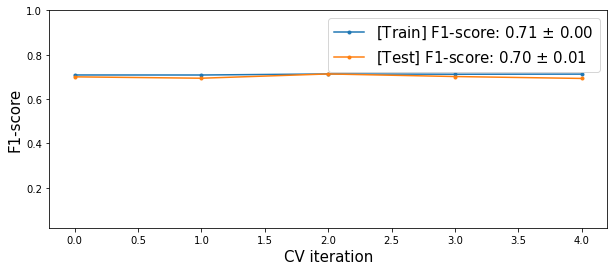

In [116]:
# Check overfitting
plot_cross_validate(clf_rf_over,
                    X_over,
                    X_test_ov,
                    y_over,
                    y_test_ov,
                    cv=5)

In [117]:
# Check permutation
permutation_imp(clf_rf_over, X_test_ov, y_test_ov, 15)

,feature,weight,std,f
0,score_bki,0.056295,0.002461,2
1,pca_address,0.028223,0.001059,5
2,hot_region_rating_80,0.012290,0.000520,19
3,days_beetwen,0.012230,0.000650,6
4,hot_education_SCH,0.011606,0.000300,11
5,income,0.011269,0.000296,3
6,hot_education_GRD,0.010022,0.001089,9
7,hot_region_rating_40,0.008320,0.000526,15
8,hot_bki_request_cat_0,0.007731,0.000410,36
9,hot_sna_1,0.007709,0.000613,20


---

RandomForest shows good results.We increased F1 and PR-AUC. Precision and Recall for positive classes also increased. So far we got besy results.

Cross validation shows that our model is not overfitted.

Feature importance has some differences with LogRegression but not significant. It is shows us that these algorithms works not in the same way.

---

<a id="sec9.8"></a>
## [9.8 Random Forest_UnderSampling](#sec9.8)
[(INDEX)](#sec2)

In [118]:
# Grid Search
rf_skf = RandomForestClassifier()
skf = StratifiedShuffleSplit(n_splits=5, random_state=42)

param = {
    'bootstrap': [True],
    'max_depth': [5, 10], #  depth of the tree
    'n_estimators': [100, 200], # The number of trees in the forest
    'max_features' : [4] # The number of features to consider when looking for the best split
}

clf_rf_under = GridSearchCV(rf_skf,
                           param,
                           scoring='roc_auc',
                           refit=True,
                           cv=skf,
                           verbose=3,
                           n_jobs=-1)
clf_rf_under.fit(X_under, y_under)

y_pred_rf_under = clf_rf_under.predict(X_test_un)
cf_matrix = confusion_matrix(y_test_un, y_pred_rf_under)

print('Best roc_auc: {:.4}, with best C: {}'.format(clf_rf_under.best_score_,
                                                    clf_rf_under.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:    0.6s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    1.2s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.5s finished


Best roc_auc: 0.7225, with best C: {'bootstrap': True, 'max_depth': 10, 'max_features': 4, 'n_estimators': 200}


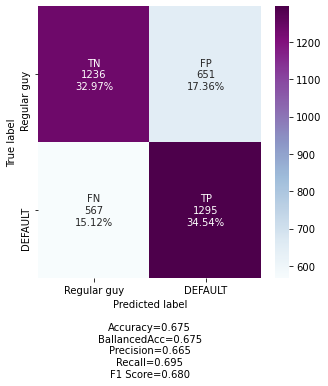

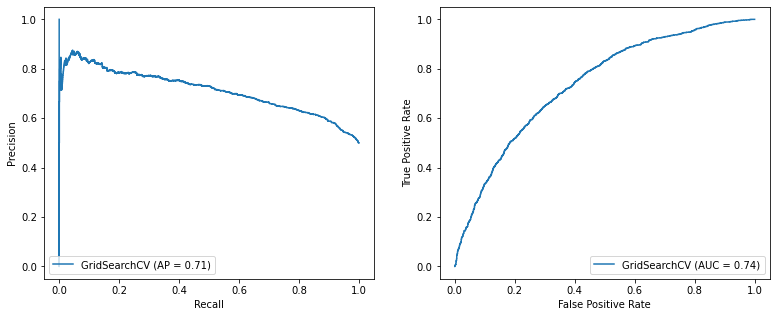

In [119]:
make_confusion_matrix(cf_matrix,categories=categories,sum_stats=True)
make_roc_auc(clf_rf_under,X_test_un,y_test_un)

In [120]:
df_report = get_scores(df_report, clf_rf_under, X_test_un, y_test_un,
                       'RandomForestClassifier_skf_under')

In [121]:
df_report

,ROC-AUC,PR-AUC,F1,precision_Neg,precision_Pos,recall_Neg,recall_Pos
LogisticRegression_Naive,0.723989,0.540146,0.059247,0.875116,0.540146,0.996084,0.031343
LogisticRegression_skf,0.724010,0.222625,0.331677,0.928516,0.222625,0.666853,0.650148
LogisticRegression_skf_over,0.730904,0.667805,0.667546,0.667106,0.667805,0.667624,0.667287
LogisticRegression_skf_under,0.746240,0.673556,0.678047,0.682599,0.673556,0.673556,0.682599
RandomForestClassifier,0.695746,0.395604,0.029364,0.873359,0.395604,0.996582,0.015248
RandomForestClassifier_skf,0.722681,0.244824,0.342697,0.921740,0.244824,0.741563,0.570945
RandomForestClassifier_skf_over,0.776414,0.700499,0.704308,0.704538,0.700499,0.696824,0.708159
RandomForestClassifier_skf_under,0.737998,0.665468,0.680147,0.685524,0.665468,0.655008,0.695489


---

With lack of data RF shows bit worse results than in a oversampled dataset. 

Also, there is a risk to be *overfitted* when we have small datasets.

---

<a id="sec9.9"></a>
## [9.9 Gradient BOOSTERS](#sec9.9)
[(INDEX)](#sec2)

We will perform same workflow for boosters. Booster produces a prediction model in the form of an ensemble of weak prediction models. 

In other words, it is learning on its own errors which it made in a previouse iteration.

Boosters work much faster than descicion trees.

<a id="sec9.9.1"></a>
## [9.9.1 Prepare Data](#sec9.9.1)

Some of boosters can work with categorical features. Then we try to use LightGBM. 

One of the advantages of such models is that you do not need to encode features by yourself.

Some of them like LightGBM will encode it automatically.

Let's prepare dataset for trainig which we saved for this reason in the feature engineering section exactly for this reason. It has not encoded columns.

In [122]:
# Extract the part of dataframe for testing
df_train_b = df_boost.query('sample == 1').drop(['sample'], axis=1)
df_valid_b = df_boost.query('sample == 0').drop(['sample'], axis=1)

X_b = df_train_b.drop(['default'], axis=1)
X_val = df_valid_b.drop(['default'], axis=1)
y_b = df_train_b.default.values

In [123]:
# convert object columns to Category
for c in X_b.columns:
    col_type = X_b[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X_b[c] = X_b[c].astype('category')

In [124]:
# Split training and test set
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_b, y_b, test_size=.2, random_state=RANDOM_SEED)

In [125]:
# prepare data for oversampling
oversample = RandomOverSampler(sampling_strategy=1)
X_b_, y_b_ = oversample.fit_resample(X_b, y_b)

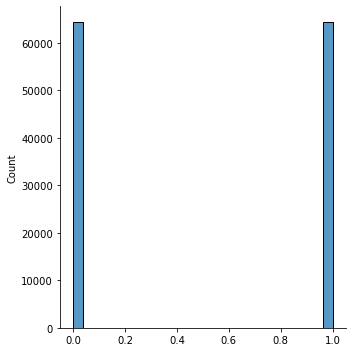

In [126]:
sns.displot(y_b_);

In [127]:
# Split training and test oversampled set
X_over_b, X_test_ov_b, y_over_b, y_test_ov_b = train_test_split(
    X_b_, y_b_, test_size=.2, random_state=RANDOM_SEED)

<a id="sec9.9.2"></a>
## [9.9.2 LightGBM](#sec9.9.2)
[(INDEX)](#sec2)

In [128]:
# Naive Model
lgb = LGBMClassifier()
lgb.fit(X_train_b, y_train_b, categorical_feature='auto')

df_report = get_scores(df_report, lgb, X_test_b,
                       y_test_b, 'LGBMClassifier')

y_pred_lgb = lgb.predict(X_test_b)
cf_matrix = confusion_matrix(y_test_b,y_pred_lgb)

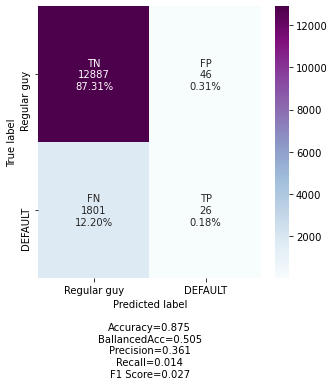

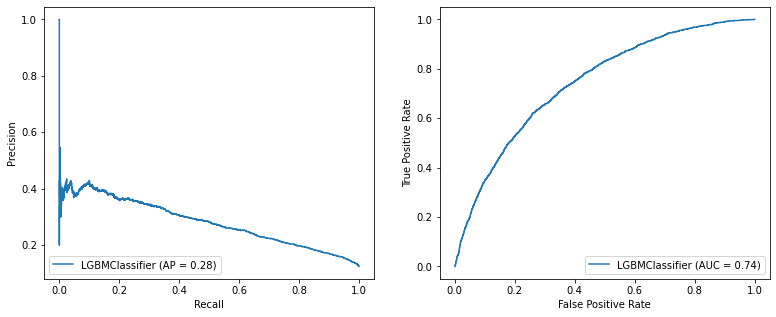

In [129]:
make_confusion_matrix(cf_matrix,categories=categories,sum_stats=True)
make_roc_auc(lgb,X_test_b,y_test_b)

In [130]:
df_report

,ROC-AUC,PR-AUC,F1,precision_Neg,precision_Pos,recall_Neg,recall_Pos
LogisticRegression_Naive,0.723989,0.540146,0.059247,0.875116,0.540146,0.996084,0.031343
LogisticRegression_skf,0.724010,0.222625,0.331677,0.928516,0.222625,0.666853,0.650148
LogisticRegression_skf_over,0.730904,0.667805,0.667546,0.667106,0.667805,0.667624,0.667287
LogisticRegression_skf_under,0.746240,0.673556,0.678047,0.682599,0.673556,0.673556,0.682599
RandomForestClassifier,0.695746,0.395604,0.029364,0.873359,0.395604,0.996582,0.015248
RandomForestClassifier_skf,0.722681,0.244824,0.342697,0.921740,0.244824,0.741563,0.570945
RandomForestClassifier_skf_over,0.776414,0.700499,0.704308,0.704538,0.700499,0.696824,0.708159
RandomForestClassifier_skf_under,0.737998,0.665468,0.680147,0.685524,0.665468,0.655008,0.695489
LGBMClassifier,0.742979,0.361111,0.027383,0.877383,0.361111,0.996443,0.014231


Nothing special here. Booster also dislike unbalanced data :(

<a id="sec9.9.3"></a>
## [9.9.3 LightGBM_Gridsearch](#sec9.9.3)
[(INDEX)](#sec2)

Well, let's skip one step and try to apply parameter's search in oversampled set with cross-validation.

All do in one cell

In [131]:
X_over_b

,education,sex,good_work,score_bki,region_rating,income,sna,first_time,foreign_passport,car_comb,age_cat,decline_cat,bki_request_cat,pca_address,days_beetwen,month,has_no_guarantor
63337,SCH,F,0,-1.811149,60,5000,1,2,N,0,oldfag,0,4,1.086059,2641,1,0
48729,SCH,F,0,-2.125379,40,16000,1,2,N,0,midle,0,0,-2.310872,2607,2,0
35681,SCH,F,0,-2.564401,50,30000,1,1,N,0,midle,0,4,-2.310872,2642,1,0
33670,SCH,M,0,-1.952243,50,200000,1,3,N,2,midle,0,0,1.086059,2570,4,0
101867,SCH,F,0,-1.367407,50,16000,4,1,N,2,midle,0,5,1.086059,2661,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128106,SCH,F,0,-1.515858,50,30000,3,3,N,2,young,0,2,1.086059,2661,1,0
103694,GRD,F,0,-1.459153,70,30000,1,1,N,1,young,1,1,-0.254275,2622,2,0
860,SCH,M,0,-2.299785,50,30000,1,4,N,1,not-young,0,1,-1.282573,2656,1,0
15795,UGR,F,0,-1.319183,50,16000,1,3,N,0,oldfag,0,6,1.086059,2565,4,0


In [132]:
lgb_skf = LGBMClassifier(class_weight='balanced',
                         categorical_feature=[0, 1, 2, 4, 6, 7, 8, 9]) # specify indexes of cat_cols
skf = StratifiedShuffleSplit(n_splits=5, random_state=RANDOM_SEED)  #5

param = {
    'learning_rate': [0.005, 0.1],
    'num_leaves': [30, 70],
    'n_estimators': [50, 100],
}

clf_lgb = GridSearchCV(lgb_skf,
                       param,
                       scoring='roc_auc',
                       cv=skf,
                       verbose=3,
                       n_jobs=-1)

clf_lgb.fit(X_over_b, y_over_b)

y_pred_lgb_clf = clf_lgb.predict(X_test_ov_b)
cf_matrix = confusion_matrix(y_test_ov_b, y_pred_lgb_clf)

print('Best roc_auc: {:.4}, with best C: {}'.format(clf_lgb.best_score_,
                                                    clf_lgb.best_params_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  31 out of  40 | elapsed:    6.8s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.8s finished


Best roc_auc: 0.8217, with best C: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 70}


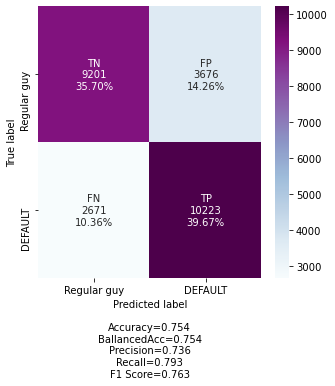

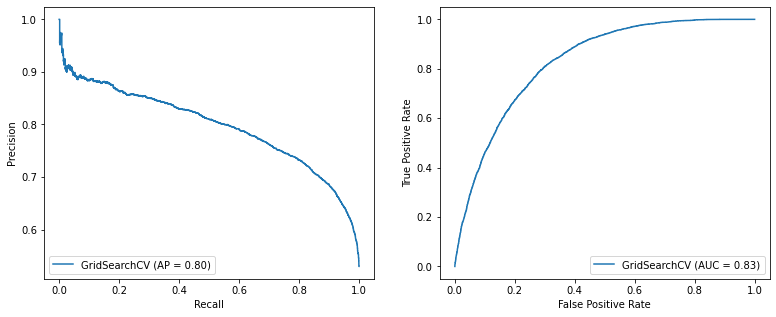

In [133]:
df_report = get_scores(df_report, clf_lgb, X_test_ov_b, y_test_ov_b,
                       'LGBMClassifier_skf_over')
make_confusion_matrix(cf_matrix,categories=categories,sum_stats=True)
make_roc_auc(clf_lgb,X_test_ov_b,y_test_ov_b)

In [134]:
df_report

,ROC-AUC,PR-AUC,F1,precision_Neg,precision_Pos,recall_Neg,recall_Pos
LogisticRegression_Naive,0.723989,0.540146,0.059247,0.875116,0.540146,0.996084,0.031343
LogisticRegression_skf,0.724010,0.222625,0.331677,0.928516,0.222625,0.666853,0.650148
LogisticRegression_skf_over,0.730904,0.667805,0.667546,0.667106,0.667805,0.667624,0.667287
LogisticRegression_skf_under,0.746240,0.673556,0.678047,0.682599,0.673556,0.673556,0.682599
RandomForestClassifier,0.695746,0.395604,0.029364,0.873359,0.395604,0.996582,0.015248
RandomForestClassifier_skf,0.722681,0.244824,0.342697,0.921740,0.244824,0.741563,0.570945
RandomForestClassifier_skf_over,0.776414,0.700499,0.704308,0.704538,0.700499,0.696824,0.708159
RandomForestClassifier_skf_under,0.737998,0.665468,0.680147,0.685524,0.665468,0.655008,0.695489
LGBMClassifier,0.742979,0.361111,0.027383,0.877383,0.361111,0.996443,0.014231
LGBMClassifier_skf_over,0.828559,0.735521,0.763110,0.775017,0.735521,0.714530,0.792849


---

Finally we got what we waanted. We can predict whith high accuracy positive class. At the same time we are not able to classiffy negative class like we did it before. But here we need to refer to the target of project. WHat is more important to us? Predict Negative or positive class?


It is notable, that Boosters works much faster and gives us bettrer results and balanced metrics for the bad data. But we need to remember the rule 'Garbage in --> Garbage out'. (Under the hood of this project we made huge amount of fails with it. Feeded to poor models by lots of garbage:)

It is prefarable to work with boosters in further.

However, Maybe our model is overfitted? Chek it out.

---

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  31 out of  40 | elapsed:    4.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    5.5s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  31 out of  40 | elapsed:    4.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    5.5s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  31 out of  40 | elapsed:    4.7s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    5.5s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  31 out of  40 | elapsed:    4.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    5.5s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  31 out of  40 | elapsed:    4.7s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    5.5s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  31 out of  40 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.3s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  31 out of  40 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.3s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  31 out of  40 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.3s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  31 out of  40 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.3s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  31 out of  40 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.3s finished


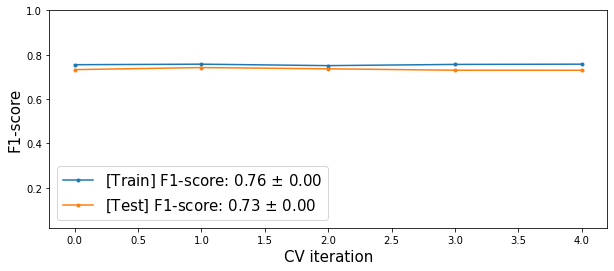

In [135]:
# Check overfitting
plot_cross_validate(clf_lgb,
                    X_over_b,
                    X_test_ov_b,
                    y_over_b,
                    y_test_ov_b,
                    cv=5)

Nope. Seems all right>>>

<a id="sec9.9.4"></a>
## [9.9.4 CATBOOST & OPTUNA parameters Search](#sec9.9.4)
[(INDEX)](#sec2)

As we might notice, using sklearn GridSearch is not best option for tuning our model for ***several reasons***:

- time consumption. It is required lots of time. 
- CPU resources. It is consumption a lot of CPU capacity and as a result - energy waste.
- Limited Search range. Sometimes we don't know in what in what range shall we search numbers for one or the other parameter. For example number of estimators in RandomForest. By preparing this project we got ***overfitting*** and ***underfitting*** infinite number of times ( and plus all above it need to wait huge amount of ***time*** while GridSearch veify all set parameters. It is annoying a lot)

***GridSearch*** is ok for people who has plenty of time :)

In this small section we try to use better solution for tuning model. Let's use ***Optuna*** and other Booster  - ***CatBooster***

We do tuning with oversampled set. While we prepared this project, we tried to use all types of data such as unbalanced, undersampled etc.

In [136]:
def objective(trial):
    '''Function to find best tuning params'''

    # Copy test and trainsets
    X_train_cb = X_over_b
    y_train_cb = y_over_b
    valid_x = X_test_ov_b
    valid_y = y_test_ov_b

    # Specify which parameters we would search
    param = {
        'cat_features': [0,1,8,9,10],
        
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "used_ram_limit": "3gb"
    }
    
    gbm = cb.CatBoostClassifier(**param)
    # Set early_stop rounds to avoid overfitting
    gbm.fit(X_train_cb, y_train_cb, eval_set=[
        (valid_x, valid_y)], verbose=0, early_stopping_rounds=20)
        
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    # We will maximize ROC_AUC metric. But you can select any other
    roc_auc_score = sklearn.metrics.roc_auc_score(valid_y, pred_labels)
    
    return roc_auc_score

In [137]:
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2021-04-18 20:17:40,562] A new study created in memory with name: no-name-15e4e160-2c88-4d27-b0b3-1ca816feb653
[I 2021-04-18 20:18:06,796] Trial 0 finished with value: 0.6664455098597329 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.02388358807171545, 'depth': 7, 'boosting_type': 'Ordered'}. Best is trial 0 with value: 0.6664455098597329.
[I 2021-04-18 20:18:30,312] Trial 1 finished with value: 0.667496347991633 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.012736313848901037, 'depth': 7, 'boosting_type': 'Ordered'}. Best is trial 1 with value: 0.667496347991633.
[I 2021-04-18 20:18:51,514] Trial 2 finished with value: 0.7290963664165487 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09819844267472203, 'depth': 7, 'boosting_type': 'Plain'}. Best is trial 2 with value: 0.7290963664165487.
[I 2021-04-18 20:19:07,747] Trial 3 finished with value: 0.6543735041425164 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel

Number of finished trials: 20
Best trial:
  Value: 0.8130947330843922
  Params: 
    objective: Logloss
    colsample_bylevel: 0.09757943199267097
    depth: 10
    boosting_type: Plain


In [138]:
cat_features = [0,1,8,9,10]

model = CatBoostClassifier(

    iterations=50,
    random_seed=42,
    learning_rate=0.33,
    colsample_bylevel = 0.09872978609022649,
    depth= 12,
    custom_loss=['AUC'],
    early_stopping_rounds=20,
    boosting_type='Plain'
)
model.fit(
    X_over_b, y_over_b,
    cat_features=cat_features,
    eval_set=(X_test_ov_b, y_test_ov_b),
    verbose=False,
    plot=False
)

In [139]:
y_pred_cb = model.predict(X_test_ov_b)
cf_matrix = confusion_matrix(y_test_ov_b, y_pred_cb)

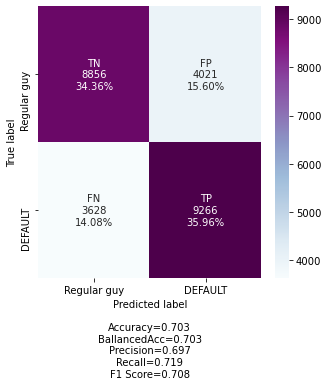

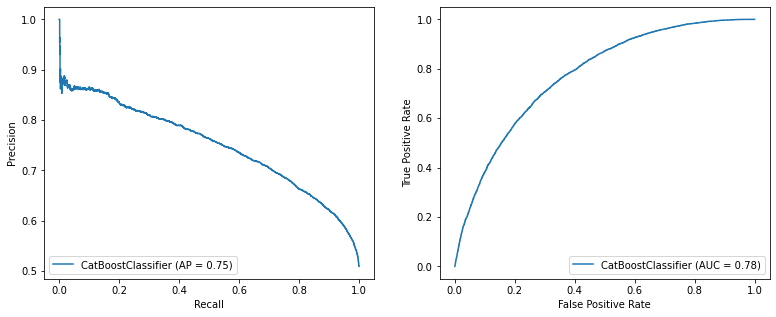

In [140]:
df_report = get_scores(df_report, model, X_test_ov_b, y_test_ov_b,
                       'CatBoost')
make_confusion_matrix(cf_matrix,categories=categories,sum_stats=True)
make_roc_auc(model,X_test_ov_b,y_test_ov_b)

In [141]:
df_report

,ROC-AUC,PR-AUC,F1,precision_Neg,precision_Pos,recall_Neg,recall_Pos
LogisticRegression_Naive,0.723989,0.540146,0.059247,0.875116,0.540146,0.996084,0.031343
LogisticRegression_skf,0.724010,0.222625,0.331677,0.928516,0.222625,0.666853,0.650148
LogisticRegression_skf_over,0.730904,0.667805,0.667546,0.667106,0.667805,0.667624,0.667287
LogisticRegression_skf_under,0.746240,0.673556,0.678047,0.682599,0.673556,0.673556,0.682599
RandomForestClassifier,0.695746,0.395604,0.029364,0.873359,0.395604,0.996582,0.015248
RandomForestClassifier_skf,0.722681,0.244824,0.342697,0.921740,0.244824,0.741563,0.570945
RandomForestClassifier_skf_over,0.776414,0.700499,0.704308,0.704538,0.700499,0.696824,0.708159
RandomForestClassifier_skf_under,0.737998,0.665468,0.680147,0.685524,0.665468,0.655008,0.695489
LGBMClassifier,0.742979,0.361111,0.027383,0.877383,0.361111,0.996443,0.014231
LGBMClassifier_skf_over,0.828559,0.735521,0.763110,0.775017,0.735521,0.714530,0.792849


<a id="sec9.10"></a>
## [9.10 Stacking_OverSample](#sec9.10)
[(INDEX)](#sec2)

Let's try to apply stacking on models, combine different models with f1 over 60%

Let's see if we can improve performance by combining soft voting model predictions.

Soft voting is argmax of the sum of the predicted probabilities. 

***NOTE_1***: For this competition best score could be obtained if we make oversampling not whole X. So that we re-assign oversampling only to X_train part

***NOTE_2***: Getting Best tuning parasmeter search for such set is not shown in dataset. BNut the workflow totally same as we did in this notebook. 

In [142]:
# For oversampling use only train set (this notebook).
oversample = RandomOverSampler(sampling_strategy=1)
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [143]:
lgbm_ = LGBMClassifier(learning_rate=0.005, n_estimators=600, num_leaves=70)
rf_ = RandomForestClassifier(bootstrap=True, max_depth=10, n_estimators=1000)
lr_ = LogisticRegression(C=1.1119999999999999, penalty='l2')
cb_ = CatBoostClassifier(

    iterations=50,
    random_seed=42,
    learning_rate=0.33,
    colsample_bylevel = 0.098,
    depth= 3,
    custom_loss=['AUC'],
    early_stopping_rounds=20,
    boosting_type='Plain'
)
clf_st = VotingClassifier(estimators=[('lr', lr_), ('rf', rf_),
                                      ('lgb', lgbm_),('cb', cb_)],
                          voting='soft')
clf_st.fit(X_over, y_over)

0:	learn: 0.6759072	total: 14ms	remaining: 684ms
1:	learn: 0.6647560	total: 27.1ms	remaining: 652ms
2:	learn: 0.6496334	total: 42.1ms	remaining: 660ms
3:	learn: 0.6432156	total: 57.1ms	remaining: 657ms
4:	learn: 0.6384381	total: 71.9ms	remaining: 647ms
5:	learn: 0.6327406	total: 86.3ms	remaining: 633ms
6:	learn: 0.6283304	total: 101ms	remaining: 620ms
7:	learn: 0.6253813	total: 115ms	remaining: 606ms
8:	learn: 0.6216071	total: 133ms	remaining: 606ms
9:	learn: 0.6199658	total: 148ms	remaining: 594ms
10:	learn: 0.6183752	total: 181ms	remaining: 640ms
11:	learn: 0.6177196	total: 196ms	remaining: 620ms
12:	learn: 0.6157276	total: 211ms	remaining: 601ms
13:	learn: 0.6154921	total: 225ms	remaining: 578ms
14:	learn: 0.6134254	total: 255ms	remaining: 595ms
15:	learn: 0.6125441	total: 288ms	remaining: 612ms
16:	learn: 0.6115844	total: 303ms	remaining: 588ms
17:	learn: 0.6109653	total: 318ms	remaining: 565ms
18:	learn: 0.6101280	total: 333ms	remaining: 543ms
19:	learn: 0.6092807	total: 348ms	rem

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.1119999999999999)),
                             ('rf',
                              RandomForestClassifier(max_depth=10,
                                                     n_estimators=1000)),
                             ('lgb',
                              LGBMClassifier(learning_rate=0.005,
                                             n_estimators=600, num_leaves=70)),
                             ('cb',
                              <catboost.core.CatBoostClassifier object at 0x0000022DB8613880>)],
                 voting='soft')

In [144]:
y_pred_clf_st = clf_st.predict(X_over)
cf_matrix = confusion_matrix(y_over,y_pred_clf_st)

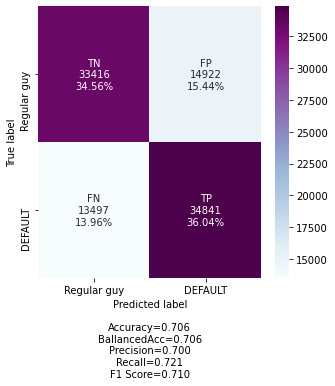

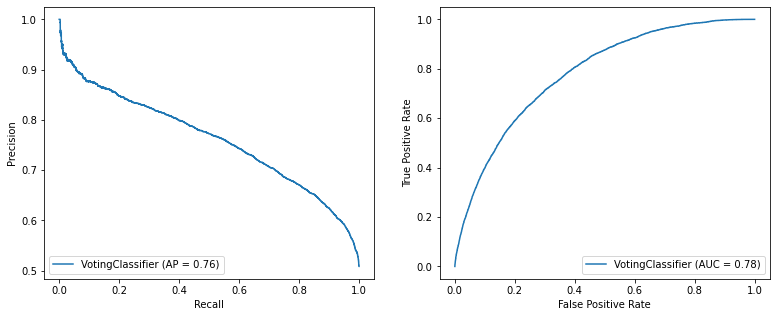

In [145]:
df_report = get_scores(df_report,clf_st, X_over,y_over, 'Voting')
make_confusion_matrix(cf_matrix, categories=categories, sum_stats=True)
make_roc_auc(clf_st,X_over, y_over)

In [146]:
df_report

,ROC-AUC,PR-AUC,F1,precision_Neg,precision_Pos,recall_Neg,recall_Pos
LogisticRegression_Naive,0.723989,0.540146,0.059247,0.875116,0.540146,0.996084,0.031343
LogisticRegression_skf,0.724010,0.222625,0.331677,0.928516,0.222625,0.666853,0.650148
LogisticRegression_skf_over,0.730904,0.667805,0.667546,0.667106,0.667805,0.667624,0.667287
LogisticRegression_skf_under,0.746240,0.673556,0.678047,0.682599,0.673556,0.673556,0.682599
RandomForestClassifier,0.695746,0.395604,0.029364,0.873359,0.395604,0.996582,0.015248
RandomForestClassifier_skf,0.722681,0.244824,0.342697,0.921740,0.244824,0.741563,0.570945
RandomForestClassifier_skf_over,0.776414,0.700499,0.704308,0.704538,0.700499,0.696824,0.708159
RandomForestClassifier_skf_under,0.737998,0.665468,0.680147,0.685524,0.665468,0.655008,0.695489
LGBMClassifier,0.742979,0.361111,0.027383,0.877383,0.361111,0.996443,0.014231
LGBMClassifier_skf_over,0.828559,0.735521,0.763110,0.775017,0.735521,0.714530,0.792849


As we can see, the voiting gives us best solution for such dataset. 

<a id="sec10"></a>
# [Conclusions](#sec10)
[(INDEX)](#sec2)

Data set is unbalanced. Oversampling showed better results for getting scores in this competition.

Logistic regression as a classical algorithm showed not bad results.

Random Forest is very slow algorithm especially when we select big number of estimators. Add to this gridsearch and you will get Infinity. However, with a reference to a confusion matrix it gives us better results than Logistic regression.

We also get a look to two Gradient Boosters. For my point of view the LightGBM is better option for such tasks. It works faster than Random forest and LogRegression. It has friendly interface and understandable tuning parameters. I did not spend too many time to learn it while I can't say same for CatBooster. 

Cat Booster gives us more or less same results (at least in this dataset) but it has a lot of tuning parameters and a little bit strange fit method. Interface is not quite frendly. I would not prefer to work with it again. However, CatBoost has some advantages. It has integrated plot_curves module and we can visualize learning progress. But I failed to run it in kaggle. Run it in JupyterNotebook.

During the implementation of the project we met OverFitting and UnderFitting of models. Need to be very careful with this issue in future. Always veufy with testing dataset given results.

Checked the feature permutation importance. Somehow, deleting of not important feature negatively impact on competition score.



Questions For Menthor:

1. Why best score can be obtained in smaller oversampled dataset?
2. Is there methods to check exactly in what state my model (overfitted or underfitted)
3. How to indrease score? What did I do wrong?
4. Why deleting uniportant features has no positive impact to score?
4. Did my conclussions are correct? After each model?


<a id="sec11"></a>
# [SUBMISSION](#sec11)
[(INDEX)](#sec2)

In [147]:
# id_test = df_test['client_id']
# id_test

0         74835
1         17527
2         75683
3         26883
4         28862
          ...  
36344     83775
36345    106254
36346     81852
36347      1971
36348     69044
Name: client_id, Length: 36349, dtype: int64

In [148]:
# submission = pd.DataFrame({'client_id': id_test,
#                            'default': clf_st.predict_proba(X_valid)[:, 1]})
# submission.to_csv('submission.csv', index=False)

# submission

,client_id,default
0,74835,0.197811
1,17527,0.682063
2,75683,0.348368
3,26883,0.358053
4,28862,0.136059
...,...,...
36344,83775,0.772532
36345,106254,0.124089
36346,81852,0.746812
36347,1971,0.676155
